Installing and downloading dependencies. We need to install this first in order to be able to import Lunar Lander Continuous in Google Colab notebook.

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     |████████████████████████████████| 448 kB 28.9 MB/s 


For our project, we are using the Lunar Lander Environment Coninuous ennvironment from Open AI Gym. 

From the Lunar Lander documentation on Open AI gym:


    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.
    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.








In [ ]:
import gym
env = gym.make("LunarLanderContinuous-v2")

In [ ]:
initial_state = env.reset()
initial_state

array([-1.09500880e-03,  1.40818143e+00, -1.10933080e-01, -1.21712245e-01,
        1.27570122e-03,  2.51279883e-02,  0.00000000e+00,  0.00000000e+00],
      dtype=float32)

    
**State Space**  

The state space consists of 8 values that are:
*   x coordinate of the lander  
*   y coordinate of the lander
*   vx, the horizontal velocity
*   vy, the vertical velocity
*   θ, the orientation in space 
*   vθ, the angular velocity
*   Left leg touching the ground (Boolean)
*   Right leg touching the ground (Boolean)


In [ ]:
action_space_ = env.action_space
action_space_

Box(-1.0, 1.0, (2,), float32)

**Action Space**  

The action is a two values array from -1 to +1 for both dimensions. The first one controls the main engine, -1.0 is off, and from 0 to 1.0, the engine’s power goes from 50% to 100% power. The engine can’t work with less than 50% of the power. The second value controls the left and right engines. From -1.0 to -0.5, it fires the left engine; from 0.5 to 1.0, it fires the right engine; from -0.5 to 0.5, the engines are off.

**Reward** 

The Reward for moving from the top of the screen to the landing pad and zero speed is from 100 to 140 points. If the lander moves away from the landing pad, it loses the reward. The episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing the main engine is -0.3 points for each frame.

Render the environment

In [ ]:
# Render non text based environments

%%bash

# install required system dependencies
apt-get install swig
!apt-get install -y xvfb x11-utils > /dev/null
!pip install gym[box2d] pyvirtualdisplay  PyOpenGL PyOpenGL-accelerate > /dev/null

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,352 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking swig (3.0.12

bash: line 4: !apt-get: command not found
bash: line 5: !pip: command not found


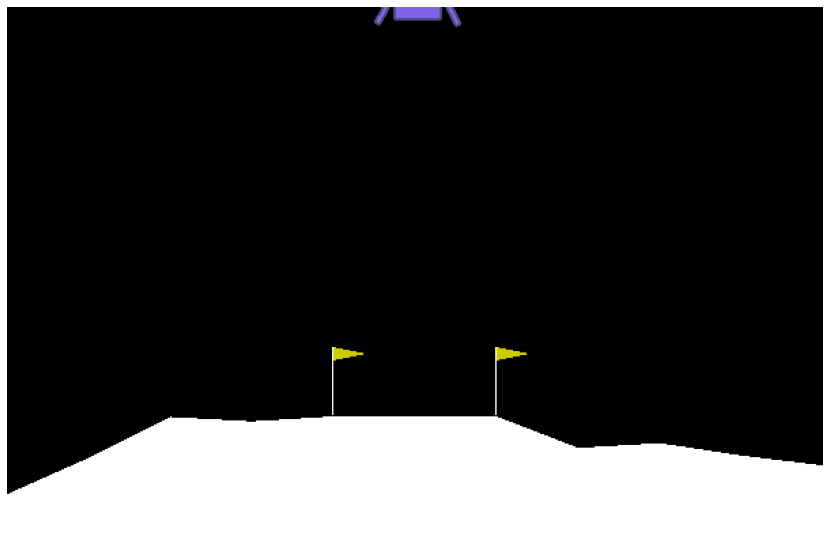

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))  # use False with Xvfb                 
_ = _display.start()
!echo $DISPLAY

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

env.reset()
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
img = ax.imshow(env.render(mode='rgb_array'))

display.display(plt.gcf())
display.clear_output(wait=True)

Importing all necessary libraries

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

Next, we construct our agent. Our agent follows a Deep Deterministic Policy Gradient algorithm. It belongs to the Actor-Critic family, but at the same time, the policy is deterministic (same input, same output/action to take). The network is updated off -policy, with samples from a replay buffer.

In [ ]:
class OUActionNoise(object):

    """
     Ornstein-Uhlenbeck Noise, to be added to the main actor to add an element of exploration to action selection.
     Code based on Open AI Baseline.
     https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py

    """
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)


class ReplayBuffer(object):

    """
     A FIFO experience replay buffer for DDPG agents.
     Arguments maximum size,input shape and number of actions.
     Stores in memory current state, new state, action,reward and terminal state.

     All of the actions and observations that the agent has taken from the beginning, 
     limited by the capacity of the memory, are stored. Then a batch of samples is randomly
     selected from this memory. This ensures that the batch is ‘shuffled’ and contains enough 
     diversity from older and newer samples to allow the network to learn weights that generalize 
     to all the scenarios that it will be required to handle.

    """

    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1- done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size) # It will pick the minimum of these two memory sizes and only sample 
                                                    # those many memories to avoid searching the whole buffer

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    """
     This is the Critic Network. Our Critic Network has 2 hidden layers with 
     2 batch normlization layers. The next layer is the Action Layer which has the action space as input and actions as output
     Each hidden layer uses ReLu activation function
     Arguments: 
     1. Beta -> Learning Rate
     2. Input Dimensions
     3. Dimensions of Fully Connected Layer 1 ( 400 as per the original paper)
     4. Dimensions of Fully Connected Layer 2 ( 300 as per original paper)
     5. Number of Actions -> Depends on the environment.
     6. Name -> To distinguish between base critic and target critic
     7. Checkpoint directory -> To save critic weights and biases.

    """
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/drive/MyDrive/RLFinal'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)    

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0]) # 1/sqrt(fc1 dims) to initialize the weights and biases of fc1 as per original paper
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data ,-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0]) #1/sqrt(fc2 dims) to initialize the weights and biases of fc2 as per original paper
        T.nn.init.uniform_(self.fc2.weight.data,-f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)


        f3 = 0.003 # constant initialization of output layer
        self.q = nn.Linear(self.fc2_dims, 1)
        #self.q = nn.Linear(self.fc2_dims,self.n_actions)
        T.nn.init.uniform_(self.q.weight.data,-f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):

        # Forward propagation function. Takes state and action as input.       
        
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):

    """
    Actor Network consists of two fully connected layers paired with two batch
    normalization layers. 
    Arguments: 
    1. Alpha -> Learning Rate
    2. Input Dimensions
    3. Dimensions of Fully Connected Layer 1 ( 400 as per the original paper)
    4. Dimensions of Fully Connected Layer 2 ( 300 as per original paper)
    5. Name -> To distinguish between base actor and target actor
    6. Checkpoint directory -> To save actor weights and biases.
    """
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/drive/MyDrive/RLFinal'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)        

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data ,-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        
        T.nn.init.uniform_(self.fc2.weight.data,-f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)        

        f3 = 0.003 # output layer initialised as per the original paper
        self.mu = nn.Linear(self.fc2_dims, self.n_actions) # Policy vector having deterministic actions
        T.nn.init.uniform_(self.mu.weight.data,-f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3) 

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):

        # Feed forward  function. The input traverses from the input via the two 
        # fully connected layers and batch norm layers, and the final output is 
        # the chosen policy.

        fwd = self.fc1(state)
        fwd = self.bn1(fwd)
        fwd = F.relu(fwd)
        fwd = self.fc2(fwd)
        fwd = self.bn2(fwd)
        fwd = F.relu(fwd) 
        fwd = T.tanh(self.mu(fwd))

        return fwd

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class Agent():
  
    """
     The Agent consists of 2 Actor-Critic pairs.
     Arguments:
     1. Alpha -> Critic's learning rate
     2. Beta -> Actor's learning rate
     3. Input Dimensions
     4. Tau -> Update parameter, rate at which target network is updated with the base network parameters, A small number
     5. Environment 
     6. Gamma -> Discount factor of agent
     7. Number of actions
     8. Maximum size of memory
     9. fc1 size
     10. fc2 size
     11. Batch size (batch learning in replay memory)

     2 pairs of Actor and Critic network are used. The Base networks
     learn the task, whereas the Target networks update the policy, therefore making
     this an off policy update process. 

     The Target networks are not trained,but every so often or gradually(based on tau) the weights from the base network
     are copied to the Target network, in order to strike a balance between not chasing a moving
     target but still having high prediction accuracy.
    """
    def __init__(self, alpha, beta, input_dims, tau, env,gamma=0.99,n_actions = 2,
                 max_size=1000000, layer1_size=400, layer2_size=300, 
                 batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions)) # Noise function, mean initialised to zeros

        self.actor = ActorNetwork(alpha, input_dims, layer1_size, layer2_size,
                                n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size, layer2_size,
                                n_actions=n_actions, name='critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size, layer2_size,
                                n_actions=n_actions, name='target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, layer1_size, layer2_size,
                                n_actions=n_actions, name='target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):

       
        self.actor.eval() # Pytorch requirement if using batchnorm. Refer here: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-py
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train() # Pytorch requirement if using batchnorm. Refer here : https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def learn(self):

      # Takes random samples from replay buffer and updates the actor
      # and critic using those values

        if self.memory.mem_cntr < self.batch_size: # learning starts only once memory buffer has at least one batch size worth of training data 
            return

        states, actions, rewards, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        actions = T.tensor(actions, dtype=T.float).to(self.critic.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()

        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions) # q value calculated using new state and action pair by target network
        critic_value = self.critic.forward(states, actions) # q value calculated using current state and action pair using base network

        target = []

        for j in range (self.batch_size):
          target.append(rewards[j] + self.gamma*critic_value_[j]*done[j]) # Target = Rewards + discounted q value
        
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size,1)


        self.critic.train()
        self.critic.optimizer.zero_grad() # stop the gradients from previous steps from accumulating
        critic_loss = F.mse_loss(target, critic_value) # compute loss between target q value and predicted q value calculated by base critic
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()

        self.actor.optimizer.zero_grad() # stop the gradients from previous steps from accumulating
        mu = self.actor.forward(states)
        self.actor.train()
        actor_loss = -self.critic.forward(states,mu) # actor loss
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters() # Update parameters for target networks

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

       # update target weights at the rate of tau
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()
        
        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_actor.load_state_dict(actor_state_dict)    
        

    def save_models(self):

      """
      Save checkpoint- saves the model weights. Useful for when we need to resume training 
      after a certain point.

      """

      self.actor.save_checkpoint()
      self.critic.save_checkpoint()
      self.target_actor.save_checkpoint()
      self.target_critic.save_checkpoint()

    def load_models(self):

      """
      Load checkpoint- loads the saved model weights. Useful for when we need to resume training 
      after a certain point.
      
      """

      self.actor.load_checkpoint()
      self.critic.load_checkpoint()
      self.target_actor.load_checkpoint()
      self.target_critic.load_checkpoint()



Function to Trace Learning Curve

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards over last 100 episodes")
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

Main Code area


In [ ]:
agent = Agent(alpha = 0.000025,beta = 0.00025,input_dims = env.observation_space.shape,tau = 0.001,env=env,gamma=0.99,
              batch_size= 64,layer1_size = 400,layer2_size = 300,n_actions = 2)

np.random.seed(0)
num_episodes = 1000

load_checkpoint = True # Set this false for first round of training. Thereafter , set it to True so that saved weights are loaded.

if load_checkpoint:
        agent.load_models()

score_history = []

for i in tqdm(range(1, num_episodes+1)):
  done = False
  score = 0
  obs = env.reset()

  while not done:
    act = agent.choose_action(obs)
    new_state,reward,done,info = env.step(act)
    agent.remember(obs,act,reward,new_state,int(done))
    agent.learn()
    score +=reward
    obs = new_state

  score_history.append(score)
  print('episode' ,i, 'score %.2f' %score, '100 game average %.2f' %np.mean(score_history[100:]))

  if i % 25 == 0:
    agent.save_models()



... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:15<4:13:17, 15.21s/it]

episode 1 score -5.54 100 game average nan


  0%|          | 2/1000 [00:31<4:22:24, 15.78s/it]

episode 2 score -11.93 100 game average nan


  0%|          | 3/1000 [00:47<4:27:49, 16.12s/it]

episode 3 score 32.98 100 game average nan


  0%|          | 4/1000 [00:56<3:39:16, 13.21s/it]

episode 4 score 162.75 100 game average nan


  0%|          | 5/1000 [01:02<2:57:11, 10.68s/it]

episode 5 score 206.69 100 game average nan


  1%|          | 6/1000 [01:19<3:29:23, 12.64s/it]

episode 6 score -10.48 100 game average nan


  1%|          | 7/1000 [01:36<3:53:29, 14.11s/it]

episode 7 score -70.49 100 game average nan


  1%|          | 8/1000 [01:53<4:09:47, 15.11s/it]

episode 8 score -63.07 100 game average nan


  1%|          | 9/1000 [02:09<4:12:34, 15.29s/it]

episode 9 score -2.43 100 game average nan


  1%|          | 10/1000 [02:23<4:08:06, 15.04s/it]

episode 10 score 5.49 100 game average nan


  1%|          | 11/1000 [02:35<3:49:39, 13.93s/it]

episode 11 score 127.72 100 game average nan


  1%|          | 12/1000 [02:39<3:00:03, 10.93s/it]

episode 12 score 212.22 100 game average nan


  1%|▏         | 13/1000 [02:53<3:16:12, 11.93s/it]

episode 13 score -42.95 100 game average nan


  1%|▏         | 14/1000 [03:06<3:20:47, 12.22s/it]

episode 14 score -13.79 100 game average nan


  2%|▏         | 15/1000 [03:19<3:24:25, 12.45s/it]

episode 15 score 21.11 100 game average nan


  2%|▏         | 16/1000 [03:34<3:36:18, 13.19s/it]

episode 16 score -52.92 100 game average nan


  2%|▏         | 17/1000 [03:47<3:38:18, 13.32s/it]

episode 17 score -37.43 100 game average nan


  2%|▏         | 18/1000 [04:01<3:37:44, 13.30s/it]

episode 18 score -26.25 100 game average nan


  2%|▏         | 19/1000 [04:09<3:10:21, 11.64s/it]

episode 19 score 171.67 100 game average nan


  2%|▏         | 20/1000 [04:22<3:20:41, 12.29s/it]

episode 20 score 2.77 100 game average nan


  2%|▏         | 21/1000 [04:36<3:27:14, 12.70s/it]

episode 21 score -8.20 100 game average nan


  2%|▏         | 22/1000 [04:38<2:33:21,  9.41s/it]

episode 22 score -26.64 100 game average nan


  2%|▏         | 23/1000 [04:47<2:32:55,  9.39s/it]

episode 23 score 174.59 100 game average nan


  2%|▏         | 24/1000 [04:49<1:56:57,  7.19s/it]

episode 24 score -155.90 100 game average nan


  2%|▎         | 25/1000 [04:53<1:38:54,  6.09s/it]

episode 25 score 164.06 100 game average nan
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


  3%|▎         | 26/1000 [05:06<2:15:43,  8.36s/it]

episode 26 score -42.82 100 game average nan


  3%|▎         | 27/1000 [05:20<2:40:19,  9.89s/it]

episode 27 score -308.68 100 game average nan


  3%|▎         | 28/1000 [05:21<2:00:01,  7.41s/it]

episode 28 score -215.93 100 game average nan


  3%|▎         | 29/1000 [05:26<1:45:23,  6.51s/it]

episode 29 score -140.13 100 game average nan


  3%|▎         | 30/1000 [05:32<1:45:08,  6.50s/it]

episode 30 score 180.14 100 game average nan


  3%|▎         | 31/1000 [05:33<1:18:25,  4.86s/it]

episode 31 score -40.95 100 game average nan


  3%|▎         | 32/1000 [05:35<1:01:09,  3.79s/it]

episode 32 score -40.01 100 game average nan


  3%|▎         | 33/1000 [05:37<54:41,  3.39s/it]  

episode 33 score -119.35 100 game average nan


  3%|▎         | 34/1000 [05:38<42:55,  2.67s/it]

episode 34 score -45.53 100 game average nan


  4%|▎         | 35/1000 [05:39<36:03,  2.24s/it]

episode 35 score -70.53 100 game average nan


  4%|▎         | 36/1000 [05:41<31:10,  1.94s/it]

episode 36 score -4.79 100 game average nan


  4%|▎         | 37/1000 [05:42<30:26,  1.90s/it]

episode 37 score -109.52 100 game average nan


  4%|▍         | 38/1000 [05:46<40:16,  2.51s/it]

episode 38 score 15.86 100 game average nan


  4%|▍         | 39/1000 [05:55<1:09:08,  4.32s/it]

episode 39 score -256.29 100 game average nan


  4%|▍         | 40/1000 [05:59<1:07:37,  4.23s/it]

episode 40 score -230.72 100 game average nan


  4%|▍         | 41/1000 [06:12<1:50:42,  6.93s/it]

episode 41 score -131.95 100 game average nan


  4%|▍         | 42/1000 [06:27<2:28:28,  9.30s/it]

episode 42 score -25.75 100 game average nan


  4%|▍         | 43/1000 [06:31<2:02:16,  7.67s/it]

episode 43 score 189.98 100 game average nan


  4%|▍         | 44/1000 [06:40<2:11:19,  8.24s/it]

episode 44 score 173.84 100 game average nan


  4%|▍         | 45/1000 [06:55<2:43:50, 10.29s/it]

episode 45 score -89.83 100 game average nan


  5%|▍         | 46/1000 [06:57<2:04:14,  7.81s/it]

episode 46 score -88.88 100 game average nan


  5%|▍         | 47/1000 [07:13<2:41:55, 10.19s/it]

episode 47 score -43.57 100 game average nan


  5%|▍         | 48/1000 [07:18<2:16:48,  8.62s/it]

episode 48 score -43.10 100 game average nan


  5%|▍         | 49/1000 [07:28<2:23:59,  9.08s/it]

episode 49 score 141.41 100 game average nan


  5%|▌         | 50/1000 [07:30<1:50:59,  7.01s/it]

episode 50 score -129.63 100 game average nan
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


  5%|▌         | 51/1000 [07:47<2:36:06,  9.87s/it]

episode 51 score -85.47 100 game average nan


  5%|▌         | 52/1000 [07:49<1:59:35,  7.57s/it]

episode 52 score -123.56 100 game average nan


  5%|▌         | 53/1000 [07:51<1:30:13,  5.72s/it]

episode 53 score -316.56 100 game average nan


  5%|▌         | 54/1000 [07:53<1:14:45,  4.74s/it]

episode 54 score -59.27 100 game average nan


  6%|▌         | 55/1000 [08:10<2:10:05,  8.26s/it]

episode 55 score -32.27 100 game average nan


  6%|▌         | 56/1000 [08:23<2:33:53,  9.78s/it]

episode 56 score 115.44 100 game average nan


  6%|▌         | 57/1000 [08:38<3:00:50, 11.51s/it]

episode 57 score -34.45 100 game average nan


  6%|▌         | 58/1000 [08:54<3:18:59, 12.67s/it]

episode 58 score -50.79 100 game average nan


  6%|▌         | 59/1000 [08:55<2:25:52,  9.30s/it]

episode 59 score -184.85 100 game average nan


  6%|▌         | 60/1000 [09:00<2:04:14,  7.93s/it]

episode 60 score -132.14 100 game average nan


  6%|▌         | 61/1000 [09:14<2:34:49,  9.89s/it]

episode 61 score -68.62 100 game average nan


  6%|▌         | 62/1000 [09:17<1:59:30,  7.64s/it]

episode 62 score -108.33 100 game average nan


  6%|▋         | 63/1000 [09:19<1:31:33,  5.86s/it]

episode 63 score -23.24 100 game average nan


  6%|▋         | 64/1000 [09:20<1:12:57,  4.68s/it]

episode 64 score -189.11 100 game average nan


  6%|▋         | 65/1000 [09:22<58:38,  3.76s/it]  

episode 65 score -232.60 100 game average nan


  7%|▋         | 66/1000 [09:38<1:54:01,  7.33s/it]

episode 66 score -78.81 100 game average nan


  7%|▋         | 67/1000 [09:42<1:38:36,  6.34s/it]

episode 67 score 221.73 100 game average nan


  7%|▋         | 68/1000 [09:43<1:15:27,  4.86s/it]

episode 68 score 11.16 100 game average nan


  7%|▋         | 69/1000 [09:48<1:16:03,  4.90s/it]

episode 69 score 232.57 100 game average nan


  7%|▋         | 70/1000 [09:58<1:40:46,  6.50s/it]

episode 70 score 110.44 100 game average nan


  7%|▋         | 71/1000 [10:00<1:18:16,  5.06s/it]

episode 71 score -390.16 100 game average nan


  7%|▋         | 72/1000 [10:02<1:03:12,  4.09s/it]

episode 72 score -17.59 100 game average nan


  7%|▋         | 73/1000 [10:09<1:19:27,  5.14s/it]

episode 73 score 292.61 100 game average nan


  7%|▋         | 74/1000 [10:15<1:21:14,  5.26s/it]

episode 74 score 234.78 100 game average nan


  8%|▊         | 75/1000 [10:20<1:21:13,  5.27s/it]

episode 75 score 230.88 100 game average nan
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


  8%|▊         | 76/1000 [10:24<1:13:52,  4.80s/it]

episode 76 score 271.57 100 game average nan


  8%|▊         | 77/1000 [10:29<1:14:20,  4.83s/it]

episode 77 score 201.08 100 game average nan


  8%|▊         | 78/1000 [10:37<1:27:39,  5.70s/it]

episode 78 score 174.20 100 game average nan


  8%|▊         | 79/1000 [10:41<1:22:32,  5.38s/it]

episode 79 score 231.85 100 game average nan


  8%|▊         | 80/1000 [10:43<1:06:45,  4.35s/it]

episode 80 score -81.96 100 game average nan


  8%|▊         | 81/1000 [10:50<1:17:11,  5.04s/it]

episode 81 score -167.70 100 game average nan


  8%|▊         | 82/1000 [10:52<1:03:36,  4.16s/it]

episode 82 score -405.42 100 game average nan


  8%|▊         | 83/1000 [10:54<51:54,  3.40s/it]  

episode 83 score -278.70 100 game average nan


  8%|▊         | 84/1000 [10:56<46:20,  3.04s/it]

episode 84 score -329.65 100 game average nan


  8%|▊         | 85/1000 [11:05<1:12:50,  4.78s/it]

episode 85 score -328.51 100 game average nan


  9%|▊         | 86/1000 [11:07<1:00:14,  3.95s/it]

episode 86 score 31.71 100 game average nan


  9%|▊         | 87/1000 [11:09<50:42,  3.33s/it]  

episode 87 score -295.42 100 game average nan


  9%|▉         | 88/1000 [11:13<54:10,  3.56s/it]

episode 88 score 213.63 100 game average nan


  9%|▉         | 89/1000 [11:18<1:00:13,  3.97s/it]

episode 89 score 208.32 100 game average nan


  9%|▉         | 90/1000 [11:20<52:29,  3.46s/it]  

episode 90 score -65.58 100 game average nan


  9%|▉         | 91/1000 [11:25<1:01:16,  4.04s/it]

episode 91 score 256.21 100 game average nan


  9%|▉         | 92/1000 [11:27<51:37,  3.41s/it]  

episode 92 score -81.80 100 game average nan


  9%|▉         | 93/1000 [11:33<1:01:08,  4.04s/it]

episode 93 score -378.02 100 game average nan


  9%|▉         | 94/1000 [11:40<1:13:49,  4.89s/it]

episode 94 score 164.55 100 game average nan


 10%|▉         | 95/1000 [11:47<1:23:00,  5.50s/it]

episode 95 score 179.38 100 game average nan


 10%|▉         | 96/1000 [11:51<1:16:29,  5.08s/it]

episode 96 score 239.76 100 game average nan


 10%|▉         | 97/1000 [11:56<1:16:55,  5.11s/it]

episode 97 score 219.77 100 game average nan


 10%|▉         | 98/1000 [12:03<1:24:19,  5.61s/it]

episode 98 score 204.65 100 game average nan


 10%|▉         | 99/1000 [12:13<1:43:51,  6.92s/it]

episode 99 score 176.42 100 game average nan


 10%|█         | 100/1000 [12:15<1:25:40,  5.71s/it]

episode 100 score -372.98 100 game average nan
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 10%|█         | 101/1000 [12:20<1:19:48,  5.33s/it]

episode 101 score 263.55 100 game average 263.55


 10%|█         | 102/1000 [12:25<1:20:08,  5.35s/it]

episode 102 score 216.28 100 game average 239.92


 10%|█         | 103/1000 [12:30<1:16:29,  5.12s/it]

episode 103 score 231.60 100 game average 237.15


 10%|█         | 104/1000 [12:42<1:47:34,  7.20s/it]

episode 104 score 161.21 100 game average 218.16


 10%|█         | 105/1000 [12:46<1:35:33,  6.41s/it]

episode 105 score 195.76 100 game average 213.68


 11%|█         | 106/1000 [12:55<1:45:24,  7.07s/it]

episode 106 score 189.25 100 game average 209.61


 11%|█         | 107/1000 [12:56<1:18:00,  5.24s/it]

episode 107 score 13.54 100 game average 181.60


 11%|█         | 108/1000 [13:04<1:29:55,  6.05s/it]

episode 108 score 123.69 100 game average 174.36


 11%|█         | 109/1000 [13:05<1:07:51,  4.57s/it]

episode 109 score -64.65 100 game average 147.80


 11%|█         | 110/1000 [13:11<1:15:14,  5.07s/it]

episode 110 score 206.88 100 game average 153.71


 11%|█         | 111/1000 [13:21<1:36:40,  6.52s/it]

episode 111 score 173.74 100 game average 155.53


 11%|█         | 112/1000 [13:24<1:20:44,  5.46s/it]

episode 112 score -155.82 100 game average 129.59


 11%|█▏        | 113/1000 [13:32<1:32:49,  6.28s/it]

episode 113 score 208.23 100 game average 135.64


 11%|█▏        | 114/1000 [13:40<1:40:07,  6.78s/it]

episode 114 score 222.93 100 game average 141.87


 12%|█▏        | 115/1000 [13:54<2:11:18,  8.90s/it]

episode 115 score -271.36 100 game average 114.32


 12%|█▏        | 116/1000 [14:04<2:15:37,  9.21s/it]

episode 116 score -423.01 100 game average 80.74


 12%|█▏        | 117/1000 [14:06<1:41:05,  6.87s/it]

episode 117 score -207.71 100 game average 63.77


 12%|█▏        | 118/1000 [14:12<1:38:07,  6.68s/it]

episode 118 score -251.49 100 game average 46.26


 12%|█▏        | 119/1000 [14:13<1:14:46,  5.09s/it]

episode 119 score -271.53 100 game average 29.53


 12%|█▏        | 120/1000 [14:21<1:25:27,  5.83s/it]

episode 120 score 194.35 100 game average 37.77


 12%|█▏        | 121/1000 [14:24<1:15:22,  5.14s/it]

episode 121 score 211.96 100 game average 46.07


 12%|█▏        | 122/1000 [14:28<1:08:42,  4.70s/it]

episode 122 score 225.01 100 game average 54.20


 12%|█▏        | 123/1000 [14:44<1:56:39,  7.98s/it]

episode 123 score -71.67 100 game average 48.73


 12%|█▏        | 124/1000 [14:49<1:46:55,  7.32s/it]

episode 124 score -88.02 100 game average 43.03


 12%|█▎        | 125/1000 [14:56<1:45:33,  7.24s/it]

episode 125 score 215.27 100 game average 49.92
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 13%|█▎        | 126/1000 [15:02<1:37:48,  6.71s/it]

episode 126 score 193.46 100 game average 55.44


 13%|█▎        | 127/1000 [15:06<1:26:52,  5.97s/it]

episode 127 score 275.18 100 game average 63.58


 13%|█▎        | 128/1000 [15:10<1:15:53,  5.22s/it]

episode 128 score 275.14 100 game average 71.14


 13%|█▎        | 129/1000 [15:15<1:17:49,  5.36s/it]

episode 129 score 277.58 100 game average 78.25


 13%|█▎        | 130/1000 [15:27<1:45:03,  7.25s/it]

episode 130 score 109.85 100 game average 79.31


 13%|█▎        | 131/1000 [15:33<1:37:45,  6.75s/it]

episode 131 score 292.97 100 game average 86.20


 13%|█▎        | 132/1000 [15:38<1:33:42,  6.48s/it]

episode 132 score 235.56 100 game average 90.87


 13%|█▎        | 133/1000 [15:42<1:20:35,  5.58s/it]

episode 133 score 280.57 100 game average 96.62


 13%|█▎        | 134/1000 [15:57<2:03:49,  8.58s/it]

episode 134 score 10.16 100 game average 94.07


 14%|█▎        | 135/1000 [15:59<1:33:59,  6.52s/it]

episode 135 score 30.42 100 game average 92.25


 14%|█▎        | 136/1000 [16:08<1:42:10,  7.10s/it]

episode 136 score 217.15 100 game average 95.72


 14%|█▎        | 137/1000 [16:14<1:40:55,  7.02s/it]

episode 137 score 257.99 100 game average 100.11


 14%|█▍        | 138/1000 [16:17<1:20:46,  5.62s/it]

episode 138 score 7.09 100 game average 97.66


 14%|█▍        | 139/1000 [16:23<1:22:31,  5.75s/it]

episode 139 score 225.17 100 game average 100.93


 14%|█▍        | 140/1000 [16:27<1:13:34,  5.13s/it]

episode 140 score 240.60 100 game average 104.42


 14%|█▍        | 141/1000 [16:36<1:33:42,  6.55s/it]

episode 141 score 168.96 100 game average 106.00


 14%|█▍        | 142/1000 [16:40<1:19:01,  5.53s/it]

episode 142 score 230.41 100 game average 108.96


 14%|█▍        | 143/1000 [16:46<1:23:48,  5.87s/it]

episode 143 score 189.46 100 game average 110.83


 14%|█▍        | 144/1000 [16:47<1:03:34,  4.46s/it]

episode 144 score -169.37 100 game average 104.46


 14%|█▍        | 145/1000 [16:52<1:03:44,  4.47s/it]

episode 145 score -233.21 100 game average 96.96


 15%|█▍        | 146/1000 [16:53<48:38,  3.42s/it]  

episode 146 score -275.99 100 game average 88.85


 15%|█▍        | 147/1000 [16:55<42:10,  2.97s/it]

episode 147 score -247.56 100 game average 81.69


 15%|█▍        | 148/1000 [16:56<33:13,  2.34s/it]

episode 148 score -193.91 100 game average 75.95


 15%|█▍        | 149/1000 [16:57<30:27,  2.15s/it]

episode 149 score -232.99 100 game average 69.65


 15%|█▌        | 150/1000 [17:00<33:18,  2.35s/it]

episode 150 score -151.34 100 game average 65.23
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 15%|█▌        | 151/1000 [17:01<28:24,  2.01s/it]

episode 151 score 4.81 100 game average 64.04


 15%|█▌        | 152/1000 [17:02<23:42,  1.68s/it]

episode 152 score -91.94 100 game average 61.04


 15%|█▌        | 153/1000 [17:05<29:38,  2.10s/it]

episode 153 score 275.64 100 game average 65.09


 15%|█▌        | 154/1000 [17:11<46:08,  3.27s/it]

episode 154 score 125.42 100 game average 66.21


 16%|█▌        | 155/1000 [17:16<52:32,  3.73s/it]

episode 155 score 247.82 100 game average 69.51


 16%|█▌        | 156/1000 [17:20<54:44,  3.89s/it]

episode 156 score 248.29 100 game average 72.70


 16%|█▌        | 157/1000 [17:24<53:53,  3.84s/it]

episode 157 score 255.62 100 game average 75.91


 16%|█▌        | 158/1000 [17:28<52:14,  3.72s/it]

episode 158 score 225.62 100 game average 78.49


 16%|█▌        | 159/1000 [17:29<43:14,  3.08s/it]

episode 159 score -43.47 100 game average 76.43


 16%|█▌        | 160/1000 [17:33<48:07,  3.44s/it]

episode 160 score 221.95 100 game average 78.85


 16%|█▌        | 161/1000 [17:39<56:07,  4.01s/it]

episode 161 score 254.58 100 game average 81.73


 16%|█▌        | 162/1000 [17:46<1:07:31,  4.83s/it]

episode 162 score -63.79 100 game average 79.39


 16%|█▋        | 163/1000 [17:46<51:10,  3.67s/it]  

episode 163 score -244.37 100 game average 74.25


 16%|█▋        | 164/1000 [17:50<51:59,  3.73s/it]

episode 164 score 283.02 100 game average 77.51


 16%|█▋        | 165/1000 [17:53<47:18,  3.40s/it]

episode 165 score 204.72 100 game average 79.47


 17%|█▋        | 166/1000 [18:01<1:04:36,  4.65s/it]

episode 166 score -133.44 100 game average 76.24


 17%|█▋        | 167/1000 [18:06<1:09:07,  4.98s/it]

episode 167 score 177.69 100 game average 77.75


 17%|█▋        | 168/1000 [18:10<1:03:19,  4.57s/it]

episode 168 score 232.65 100 game average 80.03


 17%|█▋        | 169/1000 [18:13<57:11,  4.13s/it]  

episode 169 score 7.31 100 game average 78.98


 17%|█▋        | 170/1000 [18:25<1:28:15,  6.38s/it]

episode 170 score 133.11 100 game average 79.75


 17%|█▋        | 171/1000 [18:32<1:31:02,  6.59s/it]

episode 171 score 237.69 100 game average 81.98


 17%|█▋        | 172/1000 [18:35<1:16:38,  5.55s/it]

episode 172 score -3.80 100 game average 80.78


 17%|█▋        | 173/1000 [18:48<1:49:32,  7.95s/it]

episode 173 score 32.54 100 game average 80.12


 17%|█▋        | 174/1000 [18:51<1:27:01,  6.32s/it]

episode 174 score 254.59 100 game average 82.48


 18%|█▊        | 175/1000 [18:55<1:15:46,  5.51s/it]

episode 175 score 210.39 100 game average 84.19
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 18%|█▊        | 176/1000 [18:57<1:04:26,  4.69s/it]

episode 176 score 240.29 100 game average 86.24


 18%|█▊        | 177/1000 [19:01<1:01:51,  4.51s/it]

episode 177 score 252.78 100 game average 88.40


 18%|█▊        | 178/1000 [19:10<1:16:35,  5.59s/it]

episode 178 score 158.67 100 game average 89.30


 18%|█▊        | 179/1000 [19:14<1:11:53,  5.25s/it]

episode 179 score 207.56 100 game average 90.80


 18%|█▊        | 180/1000 [19:24<1:33:15,  6.82s/it]

episode 180 score 155.74 100 game average 91.61


 18%|█▊        | 181/1000 [19:29<1:23:31,  6.12s/it]

episode 181 score 202.46 100 game average 92.98


 18%|█▊        | 182/1000 [19:33<1:15:52,  5.56s/it]

episode 182 score 261.36 100 game average 95.04


 18%|█▊        | 183/1000 [19:42<1:30:41,  6.66s/it]

episode 183 score -225.79 100 game average 91.17


 18%|█▊        | 184/1000 [19:57<2:04:33,  9.16s/it]

episode 184 score -49.47 100 game average 89.50


 18%|█▊        | 185/1000 [20:02<1:45:35,  7.77s/it]

episode 185 score 226.76 100 game average 91.11


 19%|█▊        | 186/1000 [20:06<1:29:18,  6.58s/it]

episode 186 score 232.15 100 game average 92.75


 19%|█▊        | 187/1000 [20:14<1:36:51,  7.15s/it]

episode 187 score 215.91 100 game average 94.17


 19%|█▉        | 188/1000 [20:28<2:02:42,  9.07s/it]

episode 188 score -10.58 100 game average 92.98


 19%|█▉        | 189/1000 [20:31<1:37:18,  7.20s/it]

episode 189 score 247.64 100 game average 94.71


 19%|█▉        | 190/1000 [20:32<1:15:39,  5.60s/it]

episode 190 score -6.24 100 game average 93.59


 19%|█▉        | 191/1000 [20:36<1:05:07,  4.83s/it]

episode 191 score 260.60 100 game average 95.43


 19%|█▉        | 192/1000 [20:39<1:00:29,  4.49s/it]

episode 192 score 226.67 100 game average 96.85


 19%|█▉        | 193/1000 [20:43<58:13,  4.33s/it]  

episode 193 score 206.99 100 game average 98.04


 19%|█▉        | 194/1000 [20:46<52:17,  3.89s/it]

episode 194 score 235.75 100 game average 99.50


 20%|█▉        | 195/1000 [20:49<47:38,  3.55s/it]

episode 195 score 8.45 100 game average 98.54


 20%|█▉        | 196/1000 [20:56<1:01:17,  4.57s/it]

episode 196 score 259.25 100 game average 100.22


 20%|█▉        | 197/1000 [21:01<1:02:15,  4.65s/it]

episode 197 score 236.22 100 game average 101.62


 20%|█▉        | 198/1000 [21:05<1:02:41,  4.69s/it]

episode 198 score 214.71 100 game average 102.77


 20%|█▉        | 199/1000 [21:12<1:09:07,  5.18s/it]

episode 199 score 199.45 100 game average 103.75


 20%|██        | 200/1000 [21:25<1:42:41,  7.70s/it]

episode 200 score 116.35 100 game average 103.88
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 20%|██        | 201/1000 [21:29<1:25:29,  6.42s/it]

episode 201 score 247.16 100 game average 105.30


 20%|██        | 202/1000 [21:36<1:27:09,  6.55s/it]

episode 202 score 235.31 100 game average 106.57


 20%|██        | 203/1000 [21:48<1:50:18,  8.30s/it]

episode 203 score 108.13 100 game average 106.59


 20%|██        | 204/1000 [21:55<1:44:22,  7.87s/it]

episode 204 score 208.79 100 game average 107.57


 20%|██        | 205/1000 [21:59<1:30:13,  6.81s/it]

episode 205 score 230.58 100 game average 108.74


 21%|██        | 206/1000 [22:03<1:19:23,  6.00s/it]

episode 206 score 233.71 100 game average 109.92


 21%|██        | 207/1000 [22:12<1:29:33,  6.78s/it]

episode 207 score 201.74 100 game average 110.78


 21%|██        | 208/1000 [22:14<1:11:25,  5.41s/it]

episode 208 score 247.51 100 game average 112.04


 21%|██        | 209/1000 [22:17<1:01:11,  4.64s/it]

episode 209 score 244.31 100 game average 113.26


 21%|██        | 210/1000 [22:19<51:57,  3.95s/it]  

episode 210 score 270.81 100 game average 114.69


 21%|██        | 211/1000 [22:23<50:30,  3.84s/it]

episode 211 score 257.04 100 game average 115.97


 21%|██        | 212/1000 [22:26<49:19,  3.76s/it]

episode 212 score 243.23 100 game average 117.11


 21%|██▏       | 213/1000 [22:31<52:16,  3.99s/it]

episode 213 score 183.41 100 game average 117.69


 21%|██▏       | 214/1000 [22:35<53:44,  4.10s/it]

episode 214 score 276.03 100 game average 119.08


 22%|██▏       | 215/1000 [22:39<51:26,  3.93s/it]

episode 215 score 244.73 100 game average 120.18


 22%|██▏       | 216/1000 [22:43<52:46,  4.04s/it]

episode 216 score 235.15 100 game average 121.17


 22%|██▏       | 217/1000 [22:48<55:32,  4.26s/it]

episode 217 score 202.17 100 game average 121.86


 22%|██▏       | 218/1000 [22:51<52:41,  4.04s/it]

episode 218 score 251.69 100 game average 122.96


 22%|██▏       | 219/1000 [22:55<50:19,  3.87s/it]

episode 219 score 219.50 100 game average 123.77


 22%|██▏       | 220/1000 [23:00<56:00,  4.31s/it]

episode 220 score 266.05 100 game average 124.96


 22%|██▏       | 221/1000 [23:04<55:11,  4.25s/it]

episode 221 score 189.25 100 game average 125.49


 22%|██▏       | 222/1000 [23:09<56:29,  4.36s/it]

episode 222 score 187.24 100 game average 125.99


 22%|██▏       | 223/1000 [23:14<1:00:15,  4.65s/it]

episode 223 score 240.02 100 game average 126.92


 22%|██▏       | 224/1000 [23:21<1:06:58,  5.18s/it]

episode 224 score 236.38 100 game average 127.80


 22%|██▎       | 225/1000 [23:27<1:12:51,  5.64s/it]

episode 225 score 225.58 100 game average 128.59
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 23%|██▎       | 226/1000 [23:35<1:19:46,  6.18s/it]

episode 226 score 184.76 100 game average 129.03


 23%|██▎       | 227/1000 [23:38<1:08:51,  5.35s/it]

episode 227 score 291.99 100 game average 130.31


 23%|██▎       | 228/1000 [23:44<1:09:07,  5.37s/it]

episode 228 score -204.58 100 game average 127.70


 23%|██▎       | 229/1000 [23:47<59:12,  4.61s/it]  

episode 229 score 278.45 100 game average 128.87


 23%|██▎       | 230/1000 [23:52<1:03:49,  4.97s/it]

episode 230 score 251.84 100 game average 129.81


 23%|██▎       | 231/1000 [23:59<1:09:32,  5.43s/it]

episode 231 score 225.35 100 game average 130.54


 23%|██▎       | 232/1000 [24:02<59:39,  4.66s/it]  

episode 232 score 275.83 100 game average 131.64


 23%|██▎       | 233/1000 [24:04<51:51,  4.06s/it]

episode 233 score 7.46 100 game average 130.71


 23%|██▎       | 234/1000 [24:11<1:02:23,  4.89s/it]

episode 234 score 217.00 100 game average 131.35


 24%|██▎       | 235/1000 [24:13<51:18,  4.02s/it]  

episode 235 score -407.15 100 game average 127.36


 24%|██▎       | 236/1000 [24:17<49:54,  3.92s/it]

episode 236 score -220.13 100 game average 124.81


 24%|██▎       | 237/1000 [24:23<57:23,  4.51s/it]

episode 237 score 189.19 100 game average 125.28


 24%|██▍       | 238/1000 [24:28<59:18,  4.67s/it]

episode 238 score 234.20 100 game average 126.07


 24%|██▍       | 239/1000 [24:30<50:46,  4.00s/it]

episode 239 score -187.80 100 game average 123.81


 24%|██▍       | 240/1000 [24:36<55:48,  4.41s/it]

episode 240 score 234.82 100 game average 124.60


 24%|██▍       | 241/1000 [24:45<1:13:56,  5.84s/it]

episode 241 score 197.30 100 game average 125.12


 24%|██▍       | 242/1000 [24:47<1:00:34,  4.79s/it]

episode 242 score -299.51 100 game average 122.13


 24%|██▍       | 243/1000 [24:55<1:13:34,  5.83s/it]

episode 243 score 201.86 100 game average 122.69


 24%|██▍       | 244/1000 [24:59<1:06:41,  5.29s/it]

episode 244 score 255.55 100 game average 123.61


 24%|██▍       | 245/1000 [25:03<1:00:37,  4.82s/it]

episode 245 score 202.51 100 game average 124.15


 25%|██▍       | 246/1000 [25:06<53:30,  4.26s/it]  

episode 246 score 12.63 100 game average 123.39


 25%|██▍       | 247/1000 [25:09<48:01,  3.83s/it]

episode 247 score 259.69 100 game average 124.32


 25%|██▍       | 248/1000 [25:12<43:55,  3.50s/it]

episode 248 score 195.63 100 game average 124.80


 25%|██▍       | 249/1000 [25:15<44:05,  3.52s/it]

episode 249 score 230.71 100 game average 125.51


 25%|██▌       | 250/1000 [25:19<43:45,  3.50s/it]

episode 250 score 257.48 100 game average 126.39
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 25%|██▌       | 251/1000 [25:22<43:28,  3.48s/it]

episode 251 score 210.10 100 game average 126.94


 25%|██▌       | 252/1000 [25:28<50:57,  4.09s/it]

episode 252 score 259.98 100 game average 127.82


 25%|██▌       | 253/1000 [25:32<51:35,  4.14s/it]

episode 253 score -240.38 100 game average 125.41


 25%|██▌       | 254/1000 [25:36<53:03,  4.27s/it]

episode 254 score 271.07 100 game average 126.36


 26%|██▌       | 255/1000 [25:42<58:11,  4.69s/it]

episode 255 score 232.25 100 game average 127.04


 26%|██▌       | 256/1000 [25:44<46:57,  3.79s/it]

episode 256 score 20.19 100 game average 126.36


 26%|██▌       | 257/1000 [25:45<37:50,  3.06s/it]

episode 257 score 5.02 100 game average 125.58


 26%|██▌       | 258/1000 [25:53<55:24,  4.48s/it]

episode 258 score 238.13 100 game average 126.30


 26%|██▌       | 259/1000 [25:58<56:03,  4.54s/it]

episode 259 score 231.31 100 game average 126.96


 26%|██▌       | 260/1000 [26:12<1:33:52,  7.61s/it]

episode 260 score -40.73 100 game average 125.91


 26%|██▌       | 261/1000 [26:16<1:18:10,  6.35s/it]

episode 261 score 255.39 100 game average 126.71


 26%|██▌       | 262/1000 [26:23<1:22:24,  6.70s/it]

episode 262 score 217.57 100 game average 127.27


 26%|██▋       | 263/1000 [26:27<1:12:01,  5.86s/it]

episode 263 score 288.82 100 game average 128.26


 26%|██▋       | 264/1000 [26:30<1:01:49,  5.04s/it]

episode 264 score 266.74 100 game average 129.11


 26%|██▋       | 265/1000 [26:33<53:11,  4.34s/it]  

episode 265 score 278.45 100 game average 130.01


 27%|██▋       | 266/1000 [26:40<1:02:47,  5.13s/it]

episode 266 score 237.91 100 game average 130.66


 27%|██▋       | 267/1000 [26:45<1:01:59,  5.07s/it]

episode 267 score 229.23 100 game average 131.25


 27%|██▋       | 268/1000 [26:48<54:28,  4.47s/it]  

episode 268 score 274.36 100 game average 132.11


 27%|██▋       | 269/1000 [26:52<53:51,  4.42s/it]

episode 269 score -209.83 100 game average 130.08


 27%|██▋       | 270/1000 [26:59<1:03:01,  5.18s/it]

episode 270 score 55.39 100 game average 129.64


 27%|██▋       | 271/1000 [27:01<49:48,  4.10s/it]  

episode 271 score -216.80 100 game average 127.62


 27%|██▋       | 272/1000 [27:03<41:13,  3.40s/it]

episode 272 score -258.34 100 game average 125.37


 27%|██▋       | 273/1000 [27:06<41:22,  3.41s/it]

episode 273 score 277.24 100 game average 126.25


 27%|██▋       | 274/1000 [27:10<44:23,  3.67s/it]

episode 274 score 268.14 100 game average 127.07


 28%|██▊       | 275/1000 [27:13<40:09,  3.32s/it]

episode 275 score 252.42 100 game average 127.78
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 28%|██▊       | 276/1000 [27:17<43:59,  3.65s/it]

episode 276 score 223.73 100 game average 128.33


 28%|██▊       | 277/1000 [27:21<43:11,  3.58s/it]

episode 277 score 237.60 100 game average 128.94


 28%|██▊       | 278/1000 [27:26<48:12,  4.01s/it]

episode 278 score 241.92 100 game average 129.58


 28%|██▊       | 279/1000 [27:28<43:51,  3.65s/it]

episode 279 score 222.79 100 game average 130.10


 28%|██▊       | 280/1000 [27:32<43:02,  3.59s/it]

episode 280 score 241.65 100 game average 130.72


 28%|██▊       | 281/1000 [27:37<50:04,  4.18s/it]

episode 281 score 246.59 100 game average 131.36


 28%|██▊       | 282/1000 [27:41<48:07,  4.02s/it]

episode 282 score 251.27 100 game average 132.02


 28%|██▊       | 283/1000 [27:44<43:43,  3.66s/it]

episode 283 score 262.35 100 game average 132.73


 28%|██▊       | 284/1000 [27:47<41:48,  3.50s/it]

episode 284 score 250.54 100 game average 133.37


 28%|██▊       | 285/1000 [27:54<52:10,  4.38s/it]

episode 285 score 266.12 100 game average 134.09


 29%|██▊       | 286/1000 [27:56<45:43,  3.84s/it]

episode 286 score 285.63 100 game average 134.90


 29%|██▊       | 287/1000 [28:00<44:25,  3.74s/it]

episode 287 score 240.11 100 game average 135.47


 29%|██▉       | 288/1000 [28:02<40:48,  3.44s/it]

episode 288 score -188.14 100 game average 133.74


 29%|██▉       | 289/1000 [28:10<54:00,  4.56s/it]

episode 289 score 239.72 100 game average 134.31


 29%|██▉       | 290/1000 [28:13<48:31,  4.10s/it]

episode 290 score 252.56 100 game average 134.93


 29%|██▉       | 291/1000 [28:17<50:50,  4.30s/it]

episode 291 score 269.53 100 game average 135.63


 29%|██▉       | 292/1000 [28:20<45:12,  3.83s/it]

episode 292 score 255.94 100 game average 136.26


 29%|██▉       | 293/1000 [28:23<40:53,  3.47s/it]

episode 293 score 242.82 100 game average 136.81


 29%|██▉       | 294/1000 [28:38<1:21:26,  6.92s/it]

episode 294 score -42.91 100 game average 135.89


 30%|██▉       | 295/1000 [28:44<1:20:25,  6.84s/it]

episode 295 score 219.73 100 game average 136.32


 30%|██▉       | 296/1000 [28:51<1:19:49,  6.80s/it]

episode 296 score 224.84 100 game average 136.77


 30%|██▉       | 297/1000 [28:59<1:24:57,  7.25s/it]

episode 297 score 241.61 100 game average 137.30


 30%|██▉       | 298/1000 [29:04<1:15:43,  6.47s/it]

episode 298 score 23.46 100 game average 136.72


 30%|██▉       | 299/1000 [29:08<1:07:19,  5.76s/it]

episode 299 score 293.35 100 game average 137.51


 30%|███       | 300/1000 [29:15<1:12:49,  6.24s/it]

episode 300 score 193.54 100 game average 137.79
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 30%|███       | 301/1000 [29:19<1:03:06,  5.42s/it]

episode 301 score 226.84 100 game average 138.23


 30%|███       | 302/1000 [29:23<59:40,  5.13s/it]  

episode 302 score 215.12 100 game average 138.61


 30%|███       | 303/1000 [29:38<1:33:26,  8.04s/it]

episode 303 score -33.45 100 game average 137.77


 30%|███       | 304/1000 [29:52<1:53:35,  9.79s/it]

episode 304 score 232.51 100 game average 138.23


 30%|███       | 305/1000 [29:59<1:41:34,  8.77s/it]

episode 305 score 241.15 100 game average 138.73


 31%|███       | 306/1000 [30:09<1:46:37,  9.22s/it]

episode 306 score 214.67 100 game average 139.10


 31%|███       | 307/1000 [30:15<1:36:21,  8.34s/it]

episode 307 score 214.42 100 game average 139.47


 31%|███       | 308/1000 [30:19<1:21:15,  7.04s/it]

episode 308 score 229.12 100 game average 139.90


 31%|███       | 309/1000 [30:22<1:06:09,  5.74s/it]

episode 309 score 233.23 100 game average 140.34


 31%|███       | 310/1000 [30:25<55:35,  4.83s/it]  

episode 310 score 249.67 100 game average 140.86


 31%|███       | 311/1000 [30:26<44:55,  3.91s/it]

episode 311 score -0.21 100 game average 140.20


 31%|███       | 312/1000 [30:29<41:19,  3.60s/it]

episode 312 score 193.17 100 game average 140.45


 31%|███▏      | 313/1000 [30:35<47:22,  4.14s/it]

episode 313 score 223.08 100 game average 140.83


 31%|███▏      | 314/1000 [30:43<1:01:41,  5.40s/it]

episode 314 score 236.02 100 game average 141.28


 32%|███▏      | 315/1000 [30:50<1:07:18,  5.90s/it]

episode 315 score 224.78 100 game average 141.67


 32%|███▏      | 316/1000 [30:54<59:17,  5.20s/it]  

episode 316 score 262.31 100 game average 142.23


 32%|███▏      | 317/1000 [30:57<54:51,  4.82s/it]

episode 317 score 251.87 100 game average 142.73


 32%|███▏      | 318/1000 [31:00<47:37,  4.19s/it]

episode 318 score 276.55 100 game average 143.34


 32%|███▏      | 319/1000 [31:07<57:14,  5.04s/it]

episode 319 score 254.55 100 game average 143.85


 32%|███▏      | 320/1000 [31:14<1:03:43,  5.62s/it]

episode 320 score 247.54 100 game average 144.32


 32%|███▏      | 321/1000 [31:19<1:01:21,  5.42s/it]

episode 321 score 233.55 100 game average 144.73


 32%|███▏      | 322/1000 [31:25<1:01:18,  5.43s/it]

episode 322 score 252.59 100 game average 145.21


 32%|███▏      | 323/1000 [31:32<1:09:36,  6.17s/it]

episode 323 score 198.26 100 game average 145.45


 32%|███▏      | 324/1000 [31:36<59:02,  5.24s/it]  

episode 324 score 255.45 100 game average 145.94


 32%|███▎      | 325/1000 [31:38<49:34,  4.41s/it]

episode 325 score 252.75 100 game average 146.42
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 33%|███▎      | 326/1000 [31:41<45:57,  4.09s/it]

episode 326 score 255.80 100 game average 146.90


 33%|███▎      | 327/1000 [31:45<45:41,  4.07s/it]

episode 327 score 224.12 100 game average 147.24


 33%|███▎      | 328/1000 [31:49<43:58,  3.93s/it]

episode 328 score 242.96 100 game average 147.66


 33%|███▎      | 329/1000 [31:53<44:29,  3.98s/it]

episode 329 score 263.43 100 game average 148.17


 33%|███▎      | 330/1000 [32:01<56:06,  5.02s/it]

episode 330 score 262.44 100 game average 148.66


 33%|███▎      | 331/1000 [32:03<48:47,  4.38s/it]

episode 331 score 198.76 100 game average 148.88


 33%|███▎      | 332/1000 [32:09<51:42,  4.64s/it]

episode 332 score 269.09 100 game average 149.40


 33%|███▎      | 333/1000 [32:21<1:18:07,  7.03s/it]

episode 333 score -38.67 100 game average 148.59


 33%|███▎      | 334/1000 [32:25<1:06:38,  6.00s/it]

episode 334 score 224.14 100 game average 148.91


 34%|███▎      | 335/1000 [32:28<55:58,  5.05s/it]  

episode 335 score -241.55 100 game average 147.25


 34%|███▎      | 336/1000 [32:30<48:26,  4.38s/it]

episode 336 score 261.36 100 game average 147.74


 34%|███▎      | 337/1000 [32:33<41:46,  3.78s/it]

episode 337 score 266.07 100 game average 148.24


 34%|███▍      | 338/1000 [32:41<55:01,  4.99s/it]

episode 338 score 208.73 100 game average 148.49


 34%|███▍      | 339/1000 [32:43<44:37,  4.05s/it]

episode 339 score -259.61 100 game average 146.78


 34%|███▍      | 340/1000 [32:45<39:20,  3.58s/it]

episode 340 score 258.55 100 game average 147.25


 34%|███▍      | 341/1000 [32:50<42:48,  3.90s/it]

episode 341 score 226.67 100 game average 147.58


 34%|███▍      | 342/1000 [32:52<38:07,  3.48s/it]

episode 342 score 277.90 100 game average 148.12


 34%|███▍      | 343/1000 [32:55<34:45,  3.17s/it]

episode 343 score 239.80 100 game average 148.49


 34%|███▍      | 344/1000 [32:57<33:13,  3.04s/it]

episode 344 score 260.41 100 game average 148.95


 34%|███▍      | 345/1000 [33:00<31:43,  2.91s/it]

episode 345 score 261.89 100 game average 149.41


 35%|███▍      | 346/1000 [33:10<56:03,  5.14s/it]

episode 346 score 226.68 100 game average 149.73


 35%|███▍      | 347/1000 [33:13<47:58,  4.41s/it]

episode 347 score 248.61 100 game average 150.13


 35%|███▍      | 348/1000 [33:17<47:52,  4.41s/it]

episode 348 score 281.91 100 game average 150.66


 35%|███▍      | 349/1000 [33:21<45:06,  4.16s/it]

episode 349 score 294.26 100 game average 151.24


 35%|███▌      | 350/1000 [33:24<40:44,  3.76s/it]

episode 350 score -360.67 100 game average 149.19
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 35%|███▌      | 351/1000 [33:27<37:31,  3.47s/it]

episode 351 score 269.39 100 game average 149.67


 35%|███▌      | 352/1000 [33:33<47:58,  4.44s/it]

episode 352 score -17.64 100 game average 149.00


 35%|███▌      | 353/1000 [33:36<42:50,  3.97s/it]

episode 353 score 262.23 100 game average 149.45


 35%|███▌      | 354/1000 [33:42<47:05,  4.37s/it]

episode 354 score 231.49 100 game average 149.77


 36%|███▌      | 355/1000 [33:45<44:27,  4.14s/it]

episode 355 score 225.78 100 game average 150.07


 36%|███▌      | 356/1000 [33:48<39:19,  3.66s/it]

episode 356 score 248.76 100 game average 150.46


 36%|███▌      | 357/1000 [33:50<36:15,  3.38s/it]

episode 357 score 259.97 100 game average 150.88


 36%|███▌      | 358/1000 [33:53<33:05,  3.09s/it]

episode 358 score 216.11 100 game average 151.14


 36%|███▌      | 359/1000 [33:54<27:07,  2.54s/it]

episode 359 score -366.43 100 game average 149.14


 36%|███▌      | 360/1000 [33:57<27:23,  2.57s/it]

episode 360 score 250.16 100 game average 149.53


 36%|███▌      | 361/1000 [33:58<23:25,  2.20s/it]

episode 361 score -426.50 100 game average 147.32


 36%|███▌      | 362/1000 [34:03<32:24,  3.05s/it]

episode 362 score 226.12 100 game average 147.62


 36%|███▋      | 363/1000 [34:06<30:47,  2.90s/it]

episode 363 score 275.91 100 game average 148.11


 36%|███▋      | 364/1000 [34:08<30:38,  2.89s/it]

episode 364 score 229.21 100 game average 148.41


 36%|███▋      | 365/1000 [34:12<32:54,  3.11s/it]

episode 365 score 142.55 100 game average 148.39


 37%|███▋      | 366/1000 [34:14<29:27,  2.79s/it]

episode 366 score 279.64 100 game average 148.89


 37%|███▋      | 367/1000 [34:18<31:39,  3.00s/it]

episode 367 score -298.26 100 game average 147.21


 37%|███▋      | 368/1000 [34:22<36:44,  3.49s/it]

episode 368 score 242.41 100 game average 147.57


 37%|███▋      | 369/1000 [34:25<34:12,  3.25s/it]

episode 369 score 279.58 100 game average 148.06


 37%|███▋      | 370/1000 [34:28<32:48,  3.12s/it]

episode 370 score 261.22 100 game average 148.48


 37%|███▋      | 371/1000 [34:33<40:00,  3.82s/it]

episode 371 score 277.75 100 game average 148.95


 37%|███▋      | 372/1000 [34:36<35:38,  3.41s/it]

episode 372 score 259.17 100 game average 149.36


 37%|███▋      | 373/1000 [34:38<31:47,  3.04s/it]

episode 373 score 256.71 100 game average 149.75


 37%|███▋      | 374/1000 [34:40<29:56,  2.87s/it]

episode 374 score 260.71 100 game average 150.16


 38%|███▊      | 375/1000 [34:50<49:38,  4.77s/it]

episode 375 score 212.69 100 game average 150.38
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 38%|███▊      | 376/1000 [34:52<41:05,  3.95s/it]

episode 376 score 239.80 100 game average 150.71


 38%|███▊      | 377/1000 [34:54<36:06,  3.48s/it]

episode 377 score 293.82 100 game average 151.22


 38%|███▊      | 378/1000 [34:57<33:24,  3.22s/it]

episode 378 score 258.88 100 game average 151.61


 38%|███▊      | 379/1000 [34:59<32:24,  3.13s/it]

episode 379 score 237.95 100 game average 151.92


 38%|███▊      | 380/1000 [35:03<33:00,  3.19s/it]

episode 380 score 262.57 100 game average 152.32


 38%|███▊      | 381/1000 [35:06<31:24,  3.04s/it]

episode 381 score 254.06 100 game average 152.68


 38%|███▊      | 382/1000 [35:09<31:32,  3.06s/it]

episode 382 score 271.58 100 game average 153.10


 38%|███▊      | 383/1000 [35:11<29:26,  2.86s/it]

episode 383 score 273.81 100 game average 153.53


 38%|███▊      | 384/1000 [35:14<29:44,  2.90s/it]

episode 384 score 270.13 100 game average 153.94


 38%|███▊      | 385/1000 [35:19<35:22,  3.45s/it]

episode 385 score 255.18 100 game average 154.29


 39%|███▊      | 386/1000 [35:22<35:57,  3.51s/it]

episode 386 score 212.02 100 game average 154.49


 39%|███▊      | 387/1000 [35:28<41:18,  4.04s/it]

episode 387 score 273.59 100 game average 154.91


 39%|███▉      | 388/1000 [35:32<42:20,  4.15s/it]

episode 388 score 234.09 100 game average 155.18


 39%|███▉      | 389/1000 [35:35<39:03,  3.83s/it]

episode 389 score 298.40 100 game average 155.68


 39%|███▉      | 390/1000 [35:40<42:19,  4.16s/it]

episode 390 score 263.44 100 game average 156.05


 39%|███▉      | 391/1000 [35:48<54:03,  5.33s/it]

episode 391 score 269.96 100 game average 156.44


 39%|███▉      | 392/1000 [35:51<45:09,  4.46s/it]

episode 392 score 278.88 100 game average 156.86


 39%|███▉      | 393/1000 [35:54<40:42,  4.02s/it]

episode 393 score 267.00 100 game average 157.24


 39%|███▉      | 394/1000 [35:57<38:44,  3.84s/it]

episode 394 score 269.35 100 game average 157.62


 40%|███▉      | 395/1000 [36:06<54:22,  5.39s/it]

episode 395 score 280.32 100 game average 158.04


 40%|███▉      | 396/1000 [36:10<49:25,  4.91s/it]

episode 396 score 4.37 100 game average 157.52


 40%|███▉      | 397/1000 [36:12<41:38,  4.14s/it]

episode 397 score 251.76 100 game average 157.83


 40%|███▉      | 398/1000 [36:15<37:08,  3.70s/it]

episode 398 score 266.11 100 game average 158.20


 40%|███▉      | 399/1000 [36:17<33:33,  3.35s/it]

episode 399 score 280.54 100 game average 158.61


 40%|████      | 400/1000 [36:32<1:07:36,  6.76s/it]

episode 400 score 100.66 100 game average 158.41
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 40%|████      | 401/1000 [36:34<54:06,  5.42s/it]  

episode 401 score 267.74 100 game average 158.78


 40%|████      | 402/1000 [36:40<54:25,  5.46s/it]

episode 402 score 266.00 100 game average 159.13


 40%|████      | 403/1000 [36:44<51:23,  5.16s/it]

episode 403 score 258.06 100 game average 159.46


 40%|████      | 404/1000 [36:48<46:44,  4.71s/it]

episode 404 score 239.08 100 game average 159.72


 40%|████      | 405/1000 [36:57<59:01,  5.95s/it]

episode 405 score 247.44 100 game average 160.01


 41%|████      | 406/1000 [37:02<56:22,  5.69s/it]

episode 406 score 268.51 100 game average 160.36


 41%|████      | 407/1000 [37:03<43:33,  4.41s/it]

episode 407 score -87.45 100 game average 159.55


 41%|████      | 408/1000 [37:06<36:44,  3.72s/it]

episode 408 score 223.41 100 game average 159.76


 41%|████      | 409/1000 [37:10<37:51,  3.84s/it]

episode 409 score 297.80 100 game average 160.21


 41%|████      | 410/1000 [37:19<54:52,  5.58s/it]

episode 410 score 257.61 100 game average 160.52


 41%|████      | 411/1000 [37:34<1:21:43,  8.33s/it]

episode 411 score -76.51 100 game average 159.76


 41%|████      | 412/1000 [37:36<1:04:14,  6.56s/it]

episode 412 score 221.57 100 game average 159.96


 41%|████▏     | 413/1000 [37:38<48:51,  4.99s/it]  

episode 413 score -43.80 100 game average 159.31


 41%|████▏     | 414/1000 [37:42<45:06,  4.62s/it]

episode 414 score -194.05 100 game average 158.18


 42%|████▏     | 415/1000 [37:45<40:44,  4.18s/it]

episode 415 score 273.07 100 game average 158.55


 42%|████▏     | 416/1000 [37:50<42:57,  4.41s/it]

episode 416 score 291.17 100 game average 158.97


 42%|████▏     | 417/1000 [37:52<38:05,  3.92s/it]

episode 417 score 244.59 100 game average 159.24


 42%|████▏     | 418/1000 [37:56<37:57,  3.91s/it]

episode 418 score 176.70 100 game average 159.29


 42%|████▏     | 419/1000 [37:57<29:25,  3.04s/it]

episode 419 score -29.70 100 game average 158.70


 42%|████▏     | 420/1000 [38:01<32:18,  3.34s/it]

episode 420 score 294.21 100 game average 159.12


 42%|████▏     | 421/1000 [38:04<31:41,  3.28s/it]

episode 421 score 269.10 100 game average 159.47


 42%|████▏     | 422/1000 [38:06<27:23,  2.84s/it]

episode 422 score 68.86 100 game average 159.18


 42%|████▏     | 423/1000 [38:09<27:21,  2.85s/it]

episode 423 score -90.50 100 game average 158.41


 42%|████▏     | 424/1000 [38:12<27:04,  2.82s/it]

episode 424 score 271.81 100 game average 158.76


 42%|████▎     | 425/1000 [38:16<30:06,  3.14s/it]

episode 425 score 234.61 100 game average 158.99
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 43%|████▎     | 426/1000 [38:19<29:10,  3.05s/it]

episode 426 score 264.94 100 game average 159.32


 43%|████▎     | 427/1000 [38:32<59:21,  6.22s/it]

episode 427 score 189.46 100 game average 159.41


 43%|████▎     | 428/1000 [38:39<1:01:12,  6.42s/it]

episode 428 score 241.02 100 game average 159.66


 43%|████▎     | 429/1000 [38:54<1:25:21,  8.97s/it]

episode 429 score 74.84 100 game average 159.40


 43%|████▎     | 430/1000 [38:56<1:04:25,  6.78s/it]

episode 430 score 20.15 100 game average 158.98


 43%|████▎     | 431/1000 [38:58<50:16,  5.30s/it]  

episode 431 score 10.67 100 game average 158.53


 43%|████▎     | 432/1000 [39:00<43:18,  4.57s/it]

episode 432 score 287.40 100 game average 158.92


 43%|████▎     | 433/1000 [39:11<1:00:38,  6.42s/it]

episode 433 score 254.83 100 game average 159.21


 43%|████▎     | 434/1000 [39:14<51:23,  5.45s/it]  

episode 434 score 220.57 100 game average 159.39


 44%|████▎     | 435/1000 [39:28<1:14:04,  7.87s/it]

episode 435 score 129.20 100 game average 159.30


 44%|████▎     | 436/1000 [39:37<1:18:34,  8.36s/it]

episode 436 score 253.74 100 game average 159.58


 44%|████▎     | 437/1000 [39:40<1:01:45,  6.58s/it]

episode 437 score 269.78 100 game average 159.91


 44%|████▍     | 438/1000 [39:48<1:06:39,  7.12s/it]

episode 438 score 256.40 100 game average 160.20


 44%|████▍     | 439/1000 [39:53<1:00:05,  6.43s/it]

episode 439 score 295.87 100 game average 160.60


 44%|████▍     | 440/1000 [39:56<48:59,  5.25s/it]  

episode 440 score 284.91 100 game average 160.96


 44%|████▍     | 441/1000 [39:58<42:02,  4.51s/it]

episode 441 score 269.09 100 game average 161.28


 44%|████▍     | 442/1000 [40:03<42:26,  4.56s/it]

episode 442 score 245.13 100 game average 161.52


 44%|████▍     | 443/1000 [40:06<38:07,  4.11s/it]

episode 443 score 265.94 100 game average 161.83


 44%|████▍     | 444/1000 [40:09<34:24,  3.71s/it]

episode 444 score 275.38 100 game average 162.16


 44%|████▍     | 445/1000 [40:14<37:23,  4.04s/it]

episode 445 score 243.80 100 game average 162.40


 45%|████▍     | 446/1000 [40:16<33:09,  3.59s/it]

episode 446 score 280.02 100 game average 162.74


 45%|████▍     | 447/1000 [40:20<32:42,  3.55s/it]

episode 447 score 232.40 100 game average 162.94


 45%|████▍     | 448/1000 [40:23<31:20,  3.41s/it]

episode 448 score 271.80 100 game average 163.25


 45%|████▍     | 449/1000 [40:26<30:21,  3.31s/it]

episode 449 score 262.85 100 game average 163.53


 45%|████▌     | 450/1000 [40:30<31:48,  3.47s/it]

episode 450 score 269.59 100 game average 163.84
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 45%|████▌     | 451/1000 [40:36<38:22,  4.19s/it]

episode 451 score 251.52 100 game average 164.09


 45%|████▌     | 452/1000 [40:41<40:37,  4.45s/it]

episode 452 score 251.10 100 game average 164.33


 45%|████▌     | 453/1000 [40:47<45:02,  4.94s/it]

episode 453 score 244.75 100 game average 164.56


 45%|████▌     | 454/1000 [40:51<42:06,  4.63s/it]

episode 454 score 239.64 100 game average 164.77


 46%|████▌     | 455/1000 [40:54<37:33,  4.13s/it]

episode 455 score 254.05 100 game average 165.03


 46%|████▌     | 456/1000 [41:02<48:51,  5.39s/it]

episode 456 score 227.38 100 game average 165.20


 46%|████▌     | 457/1000 [41:05<42:54,  4.74s/it]

episode 457 score 239.51 100 game average 165.41


 46%|████▌     | 458/1000 [41:08<37:34,  4.16s/it]

episode 458 score 261.00 100 game average 165.68


 46%|████▌     | 459/1000 [41:16<47:37,  5.28s/it]

episode 459 score 186.27 100 game average 165.73


 46%|████▌     | 460/1000 [41:23<52:05,  5.79s/it]

episode 460 score 222.27 100 game average 165.89


 46%|████▌     | 461/1000 [41:29<53:27,  5.95s/it]

episode 461 score 257.67 100 game average 166.14


 46%|████▌     | 462/1000 [41:34<50:25,  5.62s/it]

episode 462 score 265.93 100 game average 166.42


 46%|████▋     | 463/1000 [41:38<45:13,  5.05s/it]

episode 463 score 243.01 100 game average 166.63


 46%|████▋     | 464/1000 [41:42<42:09,  4.72s/it]

episode 464 score 232.08 100 game average 166.81


 46%|████▋     | 465/1000 [41:45<39:12,  4.40s/it]

episode 465 score 265.20 100 game average 167.08


 47%|████▋     | 466/1000 [41:49<36:57,  4.15s/it]

episode 466 score 247.48 100 game average 167.30


 47%|████▋     | 467/1000 [41:52<35:04,  3.95s/it]

episode 467 score 256.49 100 game average 167.54


 47%|████▋     | 468/1000 [41:56<34:38,  3.91s/it]

episode 468 score 242.77 100 game average 167.75


 47%|████▋     | 469/1000 [42:01<38:09,  4.31s/it]

episode 469 score 270.94 100 game average 168.03


 47%|████▋     | 470/1000 [42:04<34:29,  3.90s/it]

episode 470 score 260.41 100 game average 168.28


 47%|████▋     | 471/1000 [42:07<32:07,  3.64s/it]

episode 471 score 280.27 100 game average 168.58


 47%|████▋     | 472/1000 [42:09<27:09,  3.09s/it]

episode 472 score -217.96 100 game average 167.54


 47%|████▋     | 473/1000 [42:11<24:03,  2.74s/it]

episode 473 score -522.73 100 game average 165.69


 47%|████▋     | 474/1000 [42:13<22:58,  2.62s/it]

episode 474 score -234.56 100 game average 164.62


 48%|████▊     | 475/1000 [42:16<21:44,  2.48s/it]

episode 475 score -336.50 100 game average 163.28
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 48%|████▊     | 476/1000 [42:19<24:42,  2.83s/it]

episode 476 score 268.37 100 game average 163.56


 48%|████▊     | 477/1000 [42:23<26:07,  3.00s/it]

episode 477 score 256.22 100 game average 163.81


 48%|████▊     | 478/1000 [42:27<30:23,  3.49s/it]

episode 478 score 239.08 100 game average 164.01


 48%|████▊     | 479/1000 [42:30<29:11,  3.36s/it]

episode 479 score 297.16 100 game average 164.36


 48%|████▊     | 480/1000 [42:36<35:43,  4.12s/it]

episode 480 score 231.58 100 game average 164.54


 48%|████▊     | 481/1000 [42:41<36:45,  4.25s/it]

episode 481 score 256.04 100 game average 164.78


 48%|████▊     | 482/1000 [42:42<29:14,  3.39s/it]

episode 482 score -6.05 100 game average 164.33


 48%|████▊     | 483/1000 [42:43<23:46,  2.76s/it]

episode 483 score -142.12 100 game average 163.53


 48%|████▊     | 484/1000 [42:46<22:36,  2.63s/it]

episode 484 score -64.01 100 game average 162.94


 48%|████▊     | 485/1000 [42:50<27:52,  3.25s/it]

episode 485 score 273.11 100 game average 163.22


 49%|████▊     | 486/1000 [42:55<32:10,  3.76s/it]

episode 486 score 263.05 100 game average 163.48


 49%|████▊     | 487/1000 [42:58<28:50,  3.37s/it]

episode 487 score 279.14 100 game average 163.78


 49%|████▉     | 488/1000 [43:02<29:51,  3.50s/it]

episode 488 score 260.07 100 game average 164.03


 49%|████▉     | 489/1000 [43:06<32:20,  3.80s/it]

episode 489 score 257.79 100 game average 164.27


 49%|████▉     | 490/1000 [43:09<29:11,  3.43s/it]

episode 490 score 265.17 100 game average 164.53


 49%|████▉     | 491/1000 [43:12<28:08,  3.32s/it]

episode 491 score 234.73 100 game average 164.71


 49%|████▉     | 492/1000 [43:15<27:12,  3.21s/it]

episode 492 score 262.00 100 game average 164.95


 49%|████▉     | 493/1000 [43:22<38:14,  4.53s/it]

episode 493 score 271.56 100 game average 165.23


 49%|████▉     | 494/1000 [43:25<32:52,  3.90s/it]

episode 494 score 278.60 100 game average 165.51


 50%|████▉     | 495/1000 [43:28<31:21,  3.73s/it]

episode 495 score 252.84 100 game average 165.73


 50%|████▉     | 496/1000 [43:31<30:05,  3.58s/it]

episode 496 score 273.17 100 game average 166.01


 50%|████▉     | 497/1000 [43:36<32:06,  3.83s/it]

episode 497 score 264.08 100 game average 166.25


 50%|████▉     | 498/1000 [43:40<32:09,  3.84s/it]

episode 498 score 248.44 100 game average 166.46


 50%|████▉     | 499/1000 [43:45<35:19,  4.23s/it]

episode 499 score 227.65 100 game average 166.61


 50%|█████     | 500/1000 [43:49<35:39,  4.28s/it]

episode 500 score 232.51 100 game average 166.78
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 50%|█████     | 501/1000 [43:52<32:02,  3.85s/it]

episode 501 score -68.56 100 game average 166.19


 50%|█████     | 502/1000 [43:57<35:23,  4.26s/it]

episode 502 score 270.24 100 game average 166.45


 50%|█████     | 503/1000 [44:03<40:12,  4.85s/it]

episode 503 score -210.08 100 game average 165.52


 50%|█████     | 504/1000 [44:08<40:24,  4.89s/it]

episode 504 score 237.98 100 game average 165.69


 50%|█████     | 505/1000 [44:11<35:30,  4.30s/it]

episode 505 score 232.94 100 game average 165.86


 51%|█████     | 506/1000 [44:14<32:13,  3.91s/it]

episode 506 score 262.39 100 game average 166.10


 51%|█████     | 507/1000 [44:17<30:05,  3.66s/it]

episode 507 score 246.78 100 game average 166.30


 51%|█████     | 508/1000 [44:22<32:47,  4.00s/it]

episode 508 score 249.83 100 game average 166.50


 51%|█████     | 509/1000 [44:26<32:19,  3.95s/it]

episode 509 score 245.99 100 game average 166.70


 51%|█████     | 510/1000 [44:30<32:26,  3.97s/it]

episode 510 score 265.08 100 game average 166.94


 51%|█████     | 511/1000 [44:32<28:06,  3.45s/it]

episode 511 score -194.18 100 game average 166.06


 51%|█████     | 512/1000 [44:34<24:58,  3.07s/it]

episode 512 score -326.68 100 game average 164.86


 51%|█████▏    | 513/1000 [44:37<23:44,  2.93s/it]

episode 513 score -163.27 100 game average 164.07


 51%|█████▏    | 514/1000 [44:43<30:27,  3.76s/it]

episode 514 score 219.38 100 game average 164.20


 52%|█████▏    | 515/1000 [44:48<33:12,  4.11s/it]

episode 515 score 200.62 100 game average 164.29


 52%|█████▏    | 516/1000 [44:53<35:50,  4.44s/it]

episode 516 score 249.43 100 game average 164.49


 52%|█████▏    | 517/1000 [44:54<27:44,  3.45s/it]

episode 517 score -63.79 100 game average 163.95


 52%|█████▏    | 518/1000 [44:56<23:12,  2.89s/it]

episode 518 score 21.35 100 game average 163.60


 52%|█████▏    | 519/1000 [44:59<23:33,  2.94s/it]

episode 519 score 249.84 100 game average 163.81


 52%|█████▏    | 520/1000 [45:02<23:20,  2.92s/it]

episode 520 score 258.92 100 game average 164.04


 52%|█████▏    | 521/1000 [45:04<22:29,  2.82s/it]

episode 521 score 262.26 100 game average 164.27


 52%|█████▏    | 522/1000 [45:08<24:02,  3.02s/it]

episode 522 score 250.91 100 game average 164.48


 52%|█████▏    | 523/1000 [45:10<22:57,  2.89s/it]

episode 523 score 263.65 100 game average 164.71


 52%|█████▏    | 524/1000 [45:13<23:23,  2.95s/it]

episode 524 score 250.90 100 game average 164.91


 52%|█████▎    | 525/1000 [45:19<28:57,  3.66s/it]

episode 525 score 265.37 100 game average 165.15
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 53%|█████▎    | 526/1000 [45:24<33:47,  4.28s/it]

episode 526 score 288.57 100 game average 165.44


 53%|█████▎    | 527/1000 [45:28<31:55,  4.05s/it]

episode 527 score 275.79 100 game average 165.70


 53%|█████▎    | 528/1000 [45:31<30:20,  3.86s/it]

episode 528 score 260.05 100 game average 165.92


 53%|█████▎    | 529/1000 [45:37<33:59,  4.33s/it]

episode 529 score 260.34 100 game average 166.14


 53%|█████▎    | 530/1000 [45:42<35:37,  4.55s/it]

episode 530 score 241.26 100 game average 166.31


 53%|█████▎    | 531/1000 [45:44<30:25,  3.89s/it]

episode 531 score 256.64 100 game average 166.52


 53%|█████▎    | 532/1000 [45:47<27:35,  3.54s/it]

episode 532 score 260.86 100 game average 166.74


 53%|█████▎    | 533/1000 [45:51<28:34,  3.67s/it]

episode 533 score 286.54 100 game average 167.02


 53%|█████▎    | 534/1000 [45:54<26:56,  3.47s/it]

episode 534 score 262.12 100 game average 167.24


 54%|█████▎    | 535/1000 [45:58<29:31,  3.81s/it]

episode 535 score 221.58 100 game average 167.36


 54%|█████▎    | 536/1000 [46:01<26:08,  3.38s/it]

episode 536 score 267.20 100 game average 167.59


 54%|█████▎    | 537/1000 [46:04<25:10,  3.26s/it]

episode 537 score 264.47 100 game average 167.81


 54%|█████▍    | 538/1000 [46:08<26:31,  3.44s/it]

episode 538 score 253.81 100 game average 168.01


 54%|█████▍    | 539/1000 [46:11<25:45,  3.35s/it]

episode 539 score 267.31 100 game average 168.23


 54%|█████▍    | 540/1000 [46:14<24:46,  3.23s/it]

episode 540 score 239.34 100 game average 168.40


 54%|█████▍    | 541/1000 [46:19<29:43,  3.88s/it]

episode 541 score 264.35 100 game average 168.61


 54%|█████▍    | 542/1000 [46:25<33:21,  4.37s/it]

episode 542 score 262.74 100 game average 168.83


 54%|█████▍    | 543/1000 [46:30<36:35,  4.80s/it]

episode 543 score 249.59 100 game average 169.01


 54%|█████▍    | 544/1000 [46:38<41:50,  5.51s/it]

episode 544 score -101.56 100 game average 168.40


 55%|█████▍    | 545/1000 [46:40<34:27,  4.54s/it]

episode 545 score 289.62 100 game average 168.67


 55%|█████▍    | 546/1000 [46:46<37:11,  4.91s/it]

episode 546 score 240.12 100 game average 168.83


 55%|█████▍    | 547/1000 [46:51<38:34,  5.11s/it]

episode 547 score 279.13 100 game average 169.08


 55%|█████▍    | 548/1000 [47:00<46:35,  6.19s/it]

episode 548 score 245.80 100 game average 169.25


 55%|█████▍    | 549/1000 [47:07<47:54,  6.37s/it]

episode 549 score 243.27 100 game average 169.42


 55%|█████▌    | 550/1000 [47:10<40:33,  5.41s/it]

episode 550 score 238.28 100 game average 169.57
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 55%|█████▌    | 551/1000 [47:14<36:36,  4.89s/it]

episode 551 score 251.21 100 game average 169.75


 55%|█████▌    | 552/1000 [47:22<43:21,  5.81s/it]

episode 552 score 246.87 100 game average 169.92


 55%|█████▌    | 553/1000 [47:24<35:55,  4.82s/it]

episode 553 score 242.13 100 game average 170.08


 55%|█████▌    | 554/1000 [47:27<32:37,  4.39s/it]

episode 554 score 269.07 100 game average 170.30


 56%|█████▌    | 555/1000 [47:32<32:14,  4.35s/it]

episode 555 score 261.36 100 game average 170.50


 56%|█████▌    | 556/1000 [47:34<27:35,  3.73s/it]

episode 556 score 241.62 100 game average 170.65


 56%|█████▌    | 557/1000 [47:36<24:44,  3.35s/it]

episode 557 score 249.96 100 game average 170.83


 56%|█████▌    | 558/1000 [47:40<24:00,  3.26s/it]

episode 558 score 250.65 100 game average 171.00


 56%|█████▌    | 559/1000 [47:44<27:14,  3.71s/it]

episode 559 score 243.50 100 game average 171.16


 56%|█████▌    | 560/1000 [47:51<34:26,  4.70s/it]

episode 560 score 245.83 100 game average 171.32


 56%|█████▌    | 561/1000 [47:54<28:58,  3.96s/it]

episode 561 score 270.89 100 game average 171.54


 56%|█████▌    | 562/1000 [47:56<25:30,  3.49s/it]

episode 562 score 248.89 100 game average 171.70


 56%|█████▋    | 563/1000 [47:58<23:27,  3.22s/it]

episode 563 score 270.91 100 game average 171.92


 56%|█████▋    | 564/1000 [48:01<21:48,  3.00s/it]

episode 564 score 242.16 100 game average 172.07


 56%|█████▋    | 565/1000 [48:04<21:08,  2.92s/it]

episode 565 score 242.46 100 game average 172.22


 57%|█████▋    | 566/1000 [48:07<21:29,  2.97s/it]

episode 566 score 221.68 100 game average 172.33


 57%|█████▋    | 567/1000 [48:09<20:30,  2.84s/it]

episode 567 score 266.29 100 game average 172.53


 57%|█████▋    | 568/1000 [48:13<23:14,  3.23s/it]

episode 568 score 263.07 100 game average 172.72


 57%|█████▋    | 569/1000 [48:16<22:19,  3.11s/it]

episode 569 score 240.46 100 game average 172.87


 57%|█████▋    | 570/1000 [48:20<23:38,  3.30s/it]

episode 570 score 245.13 100 game average 173.02


 57%|█████▋    | 571/1000 [48:23<22:14,  3.11s/it]

episode 571 score 265.57 100 game average 173.22


 57%|█████▋    | 572/1000 [48:28<26:22,  3.70s/it]

episode 572 score 264.42 100 game average 173.41


 57%|█████▋    | 573/1000 [48:31<24:56,  3.51s/it]

episode 573 score 236.68 100 game average 173.54


 57%|█████▋    | 574/1000 [48:33<21:54,  3.08s/it]

episode 574 score 275.19 100 game average 173.76


 57%|█████▊    | 575/1000 [48:35<19:50,  2.80s/it]

episode 575 score 263.56 100 game average 173.95
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 58%|█████▊    | 576/1000 [48:37<17:50,  2.53s/it]

episode 576 score 283.49 100 game average 174.18


 58%|█████▊    | 577/1000 [48:40<18:20,  2.60s/it]

episode 577 score 243.80 100 game average 174.32


 58%|█████▊    | 578/1000 [48:44<21:24,  3.04s/it]

episode 578 score 243.89 100 game average 174.47


 58%|█████▊    | 579/1000 [48:47<22:05,  3.15s/it]

episode 579 score 262.67 100 game average 174.65


 58%|█████▊    | 580/1000 [48:54<29:56,  4.28s/it]

episode 580 score 206.73 100 game average 174.72


 58%|█████▊    | 581/1000 [48:56<25:46,  3.69s/it]

episode 581 score 259.34 100 game average 174.90


 58%|█████▊    | 582/1000 [49:02<29:33,  4.24s/it]

episode 582 score 267.32 100 game average 175.09


 58%|█████▊    | 583/1000 [49:06<30:03,  4.32s/it]

episode 583 score 264.83 100 game average 175.27


 58%|█████▊    | 584/1000 [49:10<27:50,  4.02s/it]

episode 584 score 248.95 100 game average 175.43


 58%|█████▊    | 585/1000 [49:14<28:58,  4.19s/it]

episode 585 score 212.89 100 game average 175.50


 59%|█████▊    | 586/1000 [49:20<31:17,  4.53s/it]

episode 586 score 252.45 100 game average 175.66


 59%|█████▊    | 587/1000 [49:23<27:36,  4.01s/it]

episode 587 score 244.05 100 game average 175.80


 59%|█████▉    | 588/1000 [49:26<26:50,  3.91s/it]

episode 588 score 232.72 100 game average 175.92


 59%|█████▉    | 589/1000 [49:29<24:36,  3.59s/it]

episode 589 score 243.03 100 game average 176.06


 59%|█████▉    | 590/1000 [49:32<23:34,  3.45s/it]

episode 590 score 243.96 100 game average 176.19


 59%|█████▉    | 591/1000 [49:35<22:41,  3.33s/it]

episode 591 score 256.52 100 game average 176.36


 59%|█████▉    | 592/1000 [49:39<23:25,  3.44s/it]

episode 592 score 227.71 100 game average 176.46


 59%|█████▉    | 593/1000 [49:42<23:17,  3.43s/it]

episode 593 score 261.21 100 game average 176.63


 59%|█████▉    | 594/1000 [49:46<24:32,  3.63s/it]

episode 594 score 266.98 100 game average 176.82


 60%|█████▉    | 595/1000 [49:49<22:58,  3.40s/it]

episode 595 score 253.54 100 game average 176.97


 60%|█████▉    | 596/1000 [49:53<24:22,  3.62s/it]

episode 596 score 217.81 100 game average 177.05


 60%|█████▉    | 597/1000 [49:55<20:02,  2.98s/it]

episode 597 score 34.54 100 game average 176.77


 60%|█████▉    | 598/1000 [49:58<19:48,  2.96s/it]

episode 598 score 265.66 100 game average 176.95


 60%|█████▉    | 599/1000 [50:01<20:28,  3.06s/it]

episode 599 score 254.21 100 game average 177.10


 60%|██████    | 600/1000 [50:03<18:38,  2.80s/it]

episode 600 score 274.92 100 game average 177.30
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 60%|██████    | 601/1000 [50:06<18:03,  2.72s/it]

episode 601 score 280.38 100 game average 177.50


 60%|██████    | 602/1000 [50:09<19:45,  2.98s/it]

episode 602 score 240.47 100 game average 177.63


 60%|██████    | 603/1000 [50:12<18:44,  2.83s/it]

episode 603 score 250.27 100 game average 177.77


 60%|██████    | 604/1000 [50:15<20:04,  3.04s/it]

episode 604 score 249.60 100 game average 177.92


 60%|██████    | 605/1000 [50:19<20:41,  3.14s/it]

episode 605 score 276.80 100 game average 178.11


 61%|██████    | 606/1000 [50:23<21:55,  3.34s/it]

episode 606 score 242.22 100 game average 178.24


 61%|██████    | 607/1000 [50:26<22:07,  3.38s/it]

episode 607 score 268.46 100 game average 178.42


 61%|██████    | 608/1000 [50:30<22:11,  3.40s/it]

episode 608 score 254.26 100 game average 178.56


 61%|██████    | 609/1000 [50:36<28:37,  4.39s/it]

episode 609 score 245.28 100 game average 178.70


 61%|██████    | 610/1000 [50:40<28:18,  4.36s/it]

episode 610 score 214.74 100 game average 178.77


 61%|██████    | 611/1000 [50:44<27:18,  4.21s/it]

episode 611 score 258.44 100 game average 178.92


 61%|██████    | 612/1000 [50:48<26:26,  4.09s/it]

episode 612 score 256.90 100 game average 179.07


 61%|██████▏   | 613/1000 [50:51<24:30,  3.80s/it]

episode 613 score 250.19 100 game average 179.21


 61%|██████▏   | 614/1000 [50:54<22:06,  3.44s/it]

episode 614 score 270.11 100 game average 179.39


 62%|██████▏   | 615/1000 [50:56<19:54,  3.10s/it]

episode 615 score 269.39 100 game average 179.56


 62%|██████▏   | 616/1000 [50:58<17:55,  2.80s/it]

episode 616 score 246.85 100 game average 179.70


 62%|██████▏   | 617/1000 [51:01<17:50,  2.79s/it]

episode 617 score 277.68 100 game average 179.88


 62%|██████▏   | 618/1000 [51:03<17:03,  2.68s/it]

episode 618 score 251.88 100 game average 180.02


 62%|██████▏   | 619/1000 [51:10<24:05,  3.80s/it]

episode 619 score 269.45 100 game average 180.20


 62%|██████▏   | 620/1000 [51:12<21:09,  3.34s/it]

episode 620 score 239.09 100 game average 180.31


 62%|██████▏   | 621/1000 [51:14<18:52,  2.99s/it]

episode 621 score 273.06 100 game average 180.49


 62%|██████▏   | 622/1000 [51:17<17:25,  2.77s/it]

episode 622 score 261.88 100 game average 180.64


 62%|██████▏   | 623/1000 [51:19<16:42,  2.66s/it]

episode 623 score 277.32 100 game average 180.83


 62%|██████▏   | 624/1000 [51:24<21:39,  3.46s/it]

episode 624 score 287.88 100 game average 181.03


 62%|██████▎   | 625/1000 [51:27<19:27,  3.11s/it]

episode 625 score 269.77 100 game average 181.20
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 63%|██████▎   | 626/1000 [51:30<19:37,  3.15s/it]

episode 626 score 247.95 100 game average 181.33


 63%|██████▎   | 627/1000 [51:33<19:04,  3.07s/it]

episode 627 score 246.30 100 game average 181.45


 63%|██████▎   | 628/1000 [51:36<19:02,  3.07s/it]

episode 628 score 256.96 100 game average 181.59


 63%|██████▎   | 629/1000 [51:38<17:50,  2.88s/it]

episode 629 score 255.72 100 game average 181.73


 63%|██████▎   | 630/1000 [51:41<17:55,  2.91s/it]

episode 630 score 232.44 100 game average 181.83


 63%|██████▎   | 631/1000 [51:44<17:24,  2.83s/it]

episode 631 score 230.96 100 game average 181.92


 63%|██████▎   | 632/1000 [51:47<17:51,  2.91s/it]

episode 632 score 243.18 100 game average 182.04


 63%|██████▎   | 633/1000 [51:49<16:38,  2.72s/it]

episode 633 score 271.34 100 game average 182.21


 63%|██████▎   | 634/1000 [51:59<28:45,  4.71s/it]

episode 634 score 260.34 100 game average 182.35


 64%|██████▎   | 635/1000 [52:02<25:24,  4.18s/it]

episode 635 score 242.19 100 game average 182.46


 64%|██████▎   | 636/1000 [52:06<24:58,  4.12s/it]

episode 636 score 252.40 100 game average 182.59


 64%|██████▎   | 637/1000 [52:09<23:53,  3.95s/it]

episode 637 score 265.93 100 game average 182.75


 64%|██████▍   | 638/1000 [52:11<20:41,  3.43s/it]

episode 638 score 252.72 100 game average 182.88


 64%|██████▍   | 639/1000 [52:13<18:20,  3.05s/it]

episode 639 score 282.39 100 game average 183.06


 64%|██████▍   | 640/1000 [52:18<20:42,  3.45s/it]

episode 640 score 300.58 100 game average 183.28


 64%|██████▍   | 641/1000 [52:21<20:34,  3.44s/it]

episode 641 score 256.17 100 game average 183.42


 64%|██████▍   | 642/1000 [52:24<18:46,  3.15s/it]

episode 642 score 250.68 100 game average 183.54


 64%|██████▍   | 643/1000 [52:27<18:09,  3.05s/it]

episode 643 score 269.61 100 game average 183.70


 64%|██████▍   | 644/1000 [52:30<19:03,  3.21s/it]

episode 644 score 235.63 100 game average 183.79


 64%|██████▍   | 645/1000 [52:33<17:43,  2.99s/it]

episode 645 score 242.46 100 game average 183.90


 65%|██████▍   | 646/1000 [52:35<16:31,  2.80s/it]

episode 646 score 238.18 100 game average 184.00


 65%|██████▍   | 647/1000 [52:37<15:14,  2.59s/it]

episode 647 score 252.23 100 game average 184.13


 65%|██████▍   | 648/1000 [52:39<14:32,  2.48s/it]

episode 648 score 231.93 100 game average 184.21


 65%|██████▍   | 649/1000 [52:42<14:27,  2.47s/it]

episode 649 score 265.42 100 game average 184.36


 65%|██████▌   | 650/1000 [52:44<14:00,  2.40s/it]

episode 650 score 21.99 100 game average 184.07
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 65%|██████▌   | 651/1000 [52:46<13:45,  2.37s/it]

episode 651 score 247.75 100 game average 184.18


 65%|██████▌   | 652/1000 [52:51<18:27,  3.18s/it]

episode 652 score 276.11 100 game average 184.35


 65%|██████▌   | 653/1000 [52:54<17:05,  2.95s/it]

episode 653 score 292.18 100 game average 184.54


 65%|██████▌   | 654/1000 [52:56<15:56,  2.76s/it]

episode 654 score 250.48 100 game average 184.66


 66%|██████▌   | 655/1000 [52:58<14:51,  2.58s/it]

episode 655 score 260.98 100 game average 184.80


 66%|██████▌   | 656/1000 [53:00<13:56,  2.43s/it]

episode 656 score 223.70 100 game average 184.87


 66%|██████▌   | 657/1000 [53:03<13:34,  2.37s/it]

episode 657 score 251.49 100 game average 184.99


 66%|██████▌   | 658/1000 [53:05<12:59,  2.28s/it]

episode 658 score 0.03 100 game average 184.66


 66%|██████▌   | 659/1000 [53:07<13:30,  2.38s/it]

episode 659 score 270.85 100 game average 184.81


 66%|██████▌   | 660/1000 [53:10<13:57,  2.46s/it]

episode 660 score 259.08 100 game average 184.94


 66%|██████▌   | 661/1000 [53:12<13:53,  2.46s/it]

episode 661 score 283.69 100 game average 185.12


 66%|██████▌   | 662/1000 [53:16<15:51,  2.82s/it]

episode 662 score 213.69 100 game average 185.17


 66%|██████▋   | 663/1000 [53:19<15:46,  2.81s/it]

episode 663 score 262.98 100 game average 185.31


 66%|██████▋   | 664/1000 [53:22<15:46,  2.82s/it]

episode 664 score 259.87 100 game average 185.44


 66%|██████▋   | 665/1000 [53:24<14:46,  2.65s/it]

episode 665 score 276.58 100 game average 185.60


 67%|██████▋   | 666/1000 [53:26<13:41,  2.46s/it]

episode 666 score 266.42 100 game average 185.75


 67%|██████▋   | 667/1000 [53:28<13:42,  2.47s/it]

episode 667 score 278.76 100 game average 185.91


 67%|██████▋   | 668/1000 [53:32<15:14,  2.75s/it]

episode 668 score 221.37 100 game average 185.97


 67%|██████▋   | 669/1000 [53:36<17:41,  3.21s/it]

episode 669 score 259.80 100 game average 186.10


 67%|██████▋   | 670/1000 [53:38<16:10,  2.94s/it]

episode 670 score 236.17 100 game average 186.19


 67%|██████▋   | 671/1000 [53:41<15:55,  2.90s/it]

episode 671 score 278.88 100 game average 186.35


 67%|██████▋   | 672/1000 [53:43<14:52,  2.72s/it]

episode 672 score 238.94 100 game average 186.44


 67%|██████▋   | 673/1000 [53:47<15:43,  2.89s/it]

episode 673 score 252.07 100 game average 186.56


 67%|██████▋   | 674/1000 [53:52<18:56,  3.49s/it]

episode 674 score 268.67 100 game average 186.70


 68%|██████▊   | 675/1000 [53:54<16:27,  3.04s/it]

episode 675 score 30.90 100 game average 186.43
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 68%|██████▊   | 676/1000 [53:57<17:10,  3.18s/it]

episode 676 score 247.15 100 game average 186.54


 68%|██████▊   | 677/1000 [54:01<17:35,  3.27s/it]

episode 677 score 211.46 100 game average 186.58


 68%|██████▊   | 678/1000 [54:03<16:07,  3.00s/it]

episode 678 score 254.96 100 game average 186.70


 68%|██████▊   | 679/1000 [54:06<15:40,  2.93s/it]

episode 679 score 253.21 100 game average 186.81


 68%|██████▊   | 680/1000 [54:09<16:15,  3.05s/it]

episode 680 score 242.44 100 game average 186.91


 68%|██████▊   | 681/1000 [54:12<16:00,  3.01s/it]

episode 681 score 18.72 100 game average 186.62


 68%|██████▊   | 682/1000 [54:16<17:15,  3.26s/it]

episode 682 score 283.75 100 game average 186.79


 68%|██████▊   | 683/1000 [54:19<16:23,  3.10s/it]

episode 683 score 271.65 100 game average 186.93


 68%|██████▊   | 684/1000 [54:21<15:40,  2.98s/it]

episode 684 score 260.79 100 game average 187.06


 68%|██████▊   | 685/1000 [54:24<14:28,  2.76s/it]

episode 685 score 289.91 100 game average 187.23


 69%|██████▊   | 686/1000 [54:27<15:33,  2.97s/it]

episode 686 score 266.95 100 game average 187.37


 69%|██████▊   | 687/1000 [54:30<14:59,  2.87s/it]

episode 687 score 263.48 100 game average 187.50


 69%|██████▉   | 688/1000 [54:31<12:22,  2.38s/it]

episode 688 score -182.92 100 game average 186.87


 69%|██████▉   | 689/1000 [54:33<12:06,  2.34s/it]

episode 689 score 247.98 100 game average 186.97


 69%|██████▉   | 690/1000 [54:35<11:52,  2.30s/it]

episode 690 score 277.98 100 game average 187.13


 69%|██████▉   | 691/1000 [54:38<12:42,  2.47s/it]

episode 691 score 233.27 100 game average 187.21


 69%|██████▉   | 692/1000 [54:48<24:02,  4.68s/it]

episode 692 score 252.37 100 game average 187.32


 69%|██████▉   | 693/1000 [54:51<20:33,  4.02s/it]

episode 693 score 265.94 100 game average 187.45


 69%|██████▉   | 694/1000 [54:53<17:31,  3.44s/it]

episode 694 score 278.35 100 game average 187.60


 70%|██████▉   | 695/1000 [54:55<15:32,  3.06s/it]

episode 695 score 269.54 100 game average 187.74


 70%|██████▉   | 696/1000 [55:01<19:56,  3.93s/it]

episode 696 score 275.23 100 game average 187.89


 70%|██████▉   | 697/1000 [55:03<17:08,  3.39s/it]

episode 697 score 259.55 100 game average 188.01


 70%|██████▉   | 698/1000 [55:08<19:50,  3.94s/it]

episode 698 score 296.56 100 game average 188.19


 70%|██████▉   | 699/1000 [55:10<17:22,  3.46s/it]

episode 699 score 232.71 100 game average 188.26


 70%|███████   | 700/1000 [55:18<23:20,  4.67s/it]

episode 700 score 253.32 100 game average 188.37
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 70%|███████   | 701/1000 [55:20<19:35,  3.93s/it]

episode 701 score 272.50 100 game average 188.51


 70%|███████   | 702/1000 [55:22<16:44,  3.37s/it]

episode 702 score 34.77 100 game average 188.26


 70%|███████   | 703/1000 [55:25<15:17,  3.09s/it]

episode 703 score 265.25 100 game average 188.38


 70%|███████   | 704/1000 [55:27<14:38,  2.97s/it]

episode 704 score 279.23 100 game average 188.53


 70%|███████   | 705/1000 [55:30<14:06,  2.87s/it]

episode 705 score 274.21 100 game average 188.67


 71%|███████   | 706/1000 [55:32<13:27,  2.75s/it]

episode 706 score 282.95 100 game average 188.83


 71%|███████   | 707/1000 [55:36<15:19,  3.14s/it]

episode 707 score -14.50 100 game average 188.50


 71%|███████   | 708/1000 [55:42<18:57,  3.90s/it]

episode 708 score 220.96 100 game average 188.55


 71%|███████   | 709/1000 [55:45<17:58,  3.70s/it]

episode 709 score 231.27 100 game average 188.62


 71%|███████   | 710/1000 [55:48<15:43,  3.25s/it]

episode 710 score 245.28 100 game average 188.71


 71%|███████   | 711/1000 [55:50<14:35,  3.03s/it]

episode 711 score 235.35 100 game average 188.79


 71%|███████   | 712/1000 [55:53<13:44,  2.86s/it]

episode 712 score 275.34 100 game average 188.93


 71%|███████▏  | 713/1000 [55:56<14:34,  3.05s/it]

episode 713 score 242.33 100 game average 189.02


 71%|███████▏  | 714/1000 [55:58<13:37,  2.86s/it]

episode 714 score 259.13 100 game average 189.13


 72%|███████▏  | 715/1000 [56:00<12:20,  2.60s/it]

episode 715 score 220.88 100 game average 189.18


 72%|███████▏  | 716/1000 [56:03<12:33,  2.65s/it]

episode 716 score 271.66 100 game average 189.32


 72%|███████▏  | 717/1000 [56:05<10:52,  2.31s/it]

episode 717 score 22.98 100 game average 189.05


 72%|███████▏  | 718/1000 [56:11<16:14,  3.46s/it]

episode 718 score 245.25 100 game average 189.14


 72%|███████▏  | 719/1000 [56:14<15:08,  3.23s/it]

episode 719 score 271.31 100 game average 189.27


 72%|███████▏  | 720/1000 [56:17<15:25,  3.31s/it]

episode 720 score 278.62 100 game average 189.41


 72%|███████▏  | 721/1000 [56:19<14:06,  3.03s/it]

episode 721 score 216.84 100 game average 189.46


 72%|███████▏  | 722/1000 [56:22<13:42,  2.96s/it]

episode 722 score 43.15 100 game average 189.22


 72%|███████▏  | 723/1000 [56:25<13:43,  2.97s/it]

episode 723 score 250.24 100 game average 189.32


 72%|███████▏  | 724/1000 [56:28<13:12,  2.87s/it]

episode 724 score 49.45 100 game average 189.10


 72%|███████▎  | 725/1000 [56:30<12:14,  2.67s/it]

episode 725 score 238.14 100 game average 189.18
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 73%|███████▎  | 726/1000 [56:33<12:36,  2.76s/it]

episode 726 score 311.28 100 game average 189.37


 73%|███████▎  | 727/1000 [56:36<12:48,  2.82s/it]

episode 727 score 271.86 100 game average 189.50


 73%|███████▎  | 728/1000 [56:39<13:04,  2.88s/it]

episode 728 score 250.88 100 game average 189.60


 73%|███████▎  | 729/1000 [56:42<12:58,  2.87s/it]

episode 729 score 252.33 100 game average 189.70


 73%|███████▎  | 730/1000 [56:45<13:06,  2.91s/it]

episode 730 score 277.25 100 game average 189.84


 73%|███████▎  | 731/1000 [56:48<13:09,  2.94s/it]

episode 731 score 263.82 100 game average 189.96


 73%|███████▎  | 732/1000 [56:50<12:20,  2.76s/it]

episode 732 score 218.78 100 game average 190.00


 73%|███████▎  | 733/1000 [56:52<11:37,  2.61s/it]

episode 733 score 285.60 100 game average 190.15


 73%|███████▎  | 734/1000 [56:55<11:54,  2.69s/it]

episode 734 score 246.51 100 game average 190.24


 74%|███████▎  | 735/1000 [56:58<11:26,  2.59s/it]

episode 735 score 269.33 100 game average 190.37


 74%|███████▎  | 736/1000 [57:01<12:24,  2.82s/it]

episode 736 score 265.46 100 game average 190.48


 74%|███████▎  | 737/1000 [57:04<12:15,  2.80s/it]

episode 737 score 280.98 100 game average 190.63


 74%|███████▍  | 738/1000 [57:05<10:11,  2.33s/it]

episode 738 score 22.19 100 game average 190.36


 74%|███████▍  | 739/1000 [57:07<09:08,  2.10s/it]

episode 739 score 51.39 100 game average 190.14


 74%|███████▍  | 740/1000 [57:10<10:12,  2.35s/it]

episode 740 score 271.93 100 game average 190.27


 74%|███████▍  | 741/1000 [57:18<18:03,  4.18s/it]

episode 741 score 264.15 100 game average 190.39


 74%|███████▍  | 742/1000 [57:22<17:24,  4.05s/it]

episode 742 score 259.66 100 game average 190.50


 74%|███████▍  | 743/1000 [57:24<15:11,  3.55s/it]

episode 743 score 282.61 100 game average 190.64


 74%|███████▍  | 744/1000 [57:26<13:19,  3.12s/it]

episode 744 score 277.59 100 game average 190.77


 74%|███████▍  | 745/1000 [57:29<12:21,  2.91s/it]

episode 745 score 229.05 100 game average 190.83


 75%|███████▍  | 746/1000 [57:31<11:13,  2.65s/it]

episode 746 score 242.91 100 game average 190.91


 75%|███████▍  | 747/1000 [57:33<10:47,  2.56s/it]

episode 747 score 265.39 100 game average 191.03


 75%|███████▍  | 748/1000 [57:35<10:20,  2.46s/it]

episode 748 score 263.55 100 game average 191.14


 75%|███████▍  | 749/1000 [57:38<10:47,  2.58s/it]

episode 749 score 237.92 100 game average 191.21


 75%|███████▌  | 750/1000 [57:41<10:38,  2.55s/it]

episode 750 score 249.57 100 game average 191.30
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 75%|███████▌  | 751/1000 [57:43<10:08,  2.44s/it]

episode 751 score 212.14 100 game average 191.33


 75%|███████▌  | 752/1000 [57:45<10:18,  2.49s/it]

episode 752 score 263.64 100 game average 191.45


 75%|███████▌  | 753/1000 [57:48<09:53,  2.40s/it]

episode 753 score 213.28 100 game average 191.48


 75%|███████▌  | 754/1000 [57:54<14:32,  3.55s/it]

episode 754 score 235.89 100 game average 191.55


 76%|███████▌  | 755/1000 [57:56<12:49,  3.14s/it]

episode 755 score 268.18 100 game average 191.66


 76%|███████▌  | 756/1000 [58:02<15:52,  3.90s/it]

episode 756 score 271.48 100 game average 191.79


 76%|███████▌  | 757/1000 [58:04<14:04,  3.48s/it]

episode 757 score 250.61 100 game average 191.88


 76%|███████▌  | 758/1000 [58:07<13:42,  3.40s/it]

episode 758 score 251.01 100 game average 191.97


 76%|███████▌  | 759/1000 [58:10<12:39,  3.15s/it]

episode 759 score 193.49 100 game average 191.97


 76%|███████▌  | 760/1000 [58:17<16:46,  4.19s/it]

episode 760 score -95.05 100 game average 191.53


 76%|███████▌  | 761/1000 [58:19<14:54,  3.74s/it]

episode 761 score 269.89 100 game average 191.65


 76%|███████▌  | 762/1000 [58:22<13:02,  3.29s/it]

episode 762 score 218.62 100 game average 191.69


 76%|███████▋  | 763/1000 [58:24<12:09,  3.08s/it]

episode 763 score 238.62 100 game average 191.76


 76%|███████▋  | 764/1000 [58:26<11:13,  2.86s/it]

episode 764 score 280.22 100 game average 191.90


 76%|███████▋  | 765/1000 [58:30<12:16,  3.13s/it]

episode 765 score 275.68 100 game average 192.02


 77%|███████▋  | 766/1000 [58:33<11:21,  2.91s/it]

episode 766 score 243.58 100 game average 192.10


 77%|███████▋  | 767/1000 [58:35<10:54,  2.81s/it]

episode 767 score 278.86 100 game average 192.23


 77%|███████▋  | 768/1000 [58:38<10:29,  2.71s/it]

episode 768 score 231.69 100 game average 192.29


 77%|███████▋  | 769/1000 [58:40<09:51,  2.56s/it]

episode 769 score 249.93 100 game average 192.37


 77%|███████▋  | 770/1000 [58:42<09:33,  2.49s/it]

episode 770 score 254.70 100 game average 192.47


 77%|███████▋  | 771/1000 [58:46<11:07,  2.92s/it]

episode 771 score 239.66 100 game average 192.54


 77%|███████▋  | 772/1000 [58:49<10:36,  2.79s/it]

episode 772 score 230.63 100 game average 192.59


 77%|███████▋  | 773/1000 [58:59<19:21,  5.12s/it]

episode 773 score 214.19 100 game average 192.63


 77%|███████▋  | 774/1000 [59:02<17:05,  4.54s/it]

episode 774 score 257.89 100 game average 192.72


 78%|███████▊  | 775/1000 [59:04<14:15,  3.80s/it]

episode 775 score 259.00 100 game average 192.82
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 78%|███████▊  | 776/1000 [59:07<12:44,  3.41s/it]

episode 776 score 227.97 100 game average 192.87


 78%|███████▊  | 777/1000 [59:09<11:29,  3.09s/it]

episode 777 score 275.08 100 game average 193.00


 78%|███████▊  | 778/1000 [59:11<10:09,  2.74s/it]

episode 778 score 23.93 100 game average 192.75


 78%|███████▊  | 779/1000 [59:18<14:23,  3.91s/it]

episode 779 score 243.39 100 game average 192.82


 78%|███████▊  | 780/1000 [59:30<23:50,  6.50s/it]

episode 780 score 147.12 100 game average 192.75


 78%|███████▊  | 781/1000 [59:33<19:27,  5.33s/it]

episode 781 score 247.64 100 game average 192.83


 78%|███████▊  | 782/1000 [59:36<16:22,  4.51s/it]

episode 782 score 270.43 100 game average 192.95


 78%|███████▊  | 783/1000 [59:38<14:23,  3.98s/it]

episode 783 score 265.46 100 game average 193.05


 78%|███████▊  | 784/1000 [59:41<12:37,  3.51s/it]

episode 784 score 242.39 100 game average 193.13


 78%|███████▊  | 785/1000 [59:43<11:41,  3.26s/it]

episode 785 score 220.81 100 game average 193.17


 79%|███████▊  | 786/1000 [59:47<11:37,  3.26s/it]

episode 786 score 297.38 100 game average 193.32


 79%|███████▊  | 787/1000 [59:52<13:53,  3.91s/it]

episode 787 score 267.64 100 game average 193.43


 79%|███████▉  | 788/1000 [59:55<13:01,  3.69s/it]

episode 788 score 269.64 100 game average 193.54


 79%|███████▉  | 789/1000 [59:58<11:23,  3.24s/it]

episode 789 score 226.12 100 game average 193.58


 79%|███████▉  | 790/1000 [1:00:00<10:27,  2.99s/it]

episode 790 score 250.25 100 game average 193.67


 79%|███████▉  | 791/1000 [1:00:02<09:50,  2.83s/it]

episode 791 score 288.57 100 game average 193.80


 79%|███████▉  | 792/1000 [1:00:15<19:58,  5.76s/it]

episode 792 score -55.02 100 game average 193.44


 79%|███████▉  | 793/1000 [1:00:18<17:21,  5.03s/it]

episode 793 score 242.66 100 game average 193.52


 79%|███████▉  | 794/1000 [1:00:21<14:49,  4.32s/it]

episode 794 score 212.00 100 game average 193.54


 80%|███████▉  | 795/1000 [1:00:29<18:48,  5.50s/it]

episode 795 score 205.19 100 game average 193.56


 80%|███████▉  | 796/1000 [1:00:33<16:58,  4.99s/it]

episode 796 score 278.88 100 game average 193.68


 80%|███████▉  | 797/1000 [1:00:36<14:32,  4.30s/it]

episode 797 score 273.71 100 game average 193.80


 80%|███████▉  | 798/1000 [1:00:39<13:14,  3.93s/it]

episode 798 score 291.38 100 game average 193.94


 80%|███████▉  | 799/1000 [1:00:44<14:08,  4.22s/it]

episode 799 score 270.49 100 game average 194.05


 80%|████████  | 800/1000 [1:00:50<15:49,  4.75s/it]

episode 800 score 271.07 100 game average 194.16
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 80%|████████  | 801/1000 [1:00:52<13:15,  4.00s/it]

episode 801 score 259.10 100 game average 194.25


 80%|████████  | 802/1000 [1:00:57<13:58,  4.23s/it]

episode 802 score 269.08 100 game average 194.35


 80%|████████  | 803/1000 [1:01:00<12:39,  3.86s/it]

episode 803 score -147.30 100 game average 193.87


 80%|████████  | 804/1000 [1:01:01<10:28,  3.21s/it]

episode 804 score -4.72 100 game average 193.59


 80%|████████  | 805/1000 [1:01:07<12:55,  3.98s/it]

episode 805 score 225.42 100 game average 193.63


 81%|████████  | 806/1000 [1:01:11<12:31,  3.87s/it]

episode 806 score 274.66 100 game average 193.75


 81%|████████  | 807/1000 [1:01:13<11:12,  3.48s/it]

episode 807 score 283.92 100 game average 193.87


 81%|████████  | 808/1000 [1:01:16<10:02,  3.14s/it]

episode 808 score 285.63 100 game average 194.00


 81%|████████  | 809/1000 [1:01:18<09:09,  2.88s/it]

episode 809 score 220.77 100 game average 194.04


 81%|████████  | 810/1000 [1:01:20<08:47,  2.78s/it]

episode 810 score 242.49 100 game average 194.11


 81%|████████  | 811/1000 [1:01:24<09:29,  3.01s/it]

episode 811 score 239.76 100 game average 194.17


 81%|████████  | 812/1000 [1:01:27<09:19,  2.97s/it]

episode 812 score 282.86 100 game average 194.30


 81%|████████▏ | 813/1000 [1:01:30<09:45,  3.13s/it]

episode 813 score 289.14 100 game average 194.43


 81%|████████▏ | 814/1000 [1:01:33<09:26,  3.05s/it]

episode 814 score 271.09 100 game average 194.54


 82%|████████▏ | 815/1000 [1:01:36<09:07,  2.96s/it]

episode 815 score 251.95 100 game average 194.62


 82%|████████▏ | 816/1000 [1:01:39<08:39,  2.83s/it]

episode 816 score 263.23 100 game average 194.72


 82%|████████▏ | 817/1000 [1:01:41<08:22,  2.75s/it]

episode 817 score 275.27 100 game average 194.83


 82%|████████▏ | 818/1000 [1:01:43<07:50,  2.59s/it]

episode 818 score 246.84 100 game average 194.90


 82%|████████▏ | 819/1000 [1:01:45<07:25,  2.46s/it]

episode 819 score 260.06 100 game average 194.99


 82%|████████▏ | 820/1000 [1:01:50<09:07,  3.04s/it]

episode 820 score 280.61 100 game average 195.11


 82%|████████▏ | 821/1000 [1:01:52<08:27,  2.84s/it]

episode 821 score 280.48 100 game average 195.23


 82%|████████▏ | 822/1000 [1:01:56<08:49,  2.97s/it]

episode 822 score 246.13 100 game average 195.30


 82%|████████▏ | 823/1000 [1:02:01<10:47,  3.66s/it]

episode 823 score 249.74 100 game average 195.37


 82%|████████▏ | 824/1000 [1:02:04<10:06,  3.45s/it]

episode 824 score 276.25 100 game average 195.49


 82%|████████▎ | 825/1000 [1:02:06<09:25,  3.23s/it]

episode 825 score 287.84 100 game average 195.61
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 83%|████████▎ | 826/1000 [1:02:09<08:39,  2.99s/it]

episode 826 score 275.31 100 game average 195.72


 83%|████████▎ | 827/1000 [1:02:12<08:52,  3.08s/it]

episode 827 score 241.47 100 game average 195.79


 83%|████████▎ | 828/1000 [1:02:15<08:15,  2.88s/it]

episode 828 score 243.37 100 game average 195.85


 83%|████████▎ | 829/1000 [1:02:18<08:30,  2.99s/it]

episode 829 score 280.96 100 game average 195.97


 83%|████████▎ | 830/1000 [1:02:22<09:18,  3.29s/it]

episode 830 score 252.53 100 game average 196.05


 83%|████████▎ | 831/1000 [1:02:24<08:13,  2.92s/it]

episode 831 score 252.94 100 game average 196.12


 83%|████████▎ | 832/1000 [1:02:26<07:31,  2.69s/it]

episode 832 score 250.86 100 game average 196.20


 83%|████████▎ | 833/1000 [1:02:29<07:20,  2.64s/it]

episode 833 score 243.64 100 game average 196.26


 83%|████████▎ | 834/1000 [1:02:33<09:11,  3.32s/it]

episode 834 score 245.85 100 game average 196.33


 84%|████████▎ | 835/1000 [1:02:36<08:27,  3.08s/it]

episode 835 score 266.07 100 game average 196.42


 84%|████████▎ | 836/1000 [1:02:38<07:46,  2.85s/it]

episode 836 score 263.05 100 game average 196.52


 84%|████████▎ | 837/1000 [1:02:40<07:03,  2.60s/it]

episode 837 score 284.04 100 game average 196.63


 84%|████████▍ | 838/1000 [1:02:49<11:48,  4.37s/it]

episode 838 score 273.63 100 game average 196.74


 84%|████████▍ | 839/1000 [1:02:51<10:09,  3.79s/it]

episode 839 score 259.58 100 game average 196.82


 84%|████████▍ | 840/1000 [1:02:53<08:52,  3.33s/it]

episode 840 score 252.34 100 game average 196.90


 84%|████████▍ | 841/1000 [1:02:57<08:59,  3.40s/it]

episode 841 score 279.42 100 game average 197.01


 84%|████████▍ | 842/1000 [1:03:05<12:31,  4.75s/it]

episode 842 score 263.02 100 game average 197.10


 84%|████████▍ | 843/1000 [1:03:08<11:13,  4.29s/it]

episode 843 score 268.89 100 game average 197.20


 84%|████████▍ | 844/1000 [1:03:12<10:55,  4.20s/it]

episode 844 score 256.16 100 game average 197.27


 84%|████████▍ | 845/1000 [1:03:14<09:24,  3.64s/it]

episode 845 score 255.70 100 game average 197.35


 85%|████████▍ | 846/1000 [1:03:17<08:26,  3.29s/it]

episode 846 score 236.24 100 game average 197.41


 85%|████████▍ | 847/1000 [1:03:19<07:47,  3.05s/it]

episode 847 score 289.89 100 game average 197.53


 85%|████████▍ | 848/1000 [1:03:23<07:56,  3.13s/it]

episode 848 score 190.64 100 game average 197.52


 85%|████████▍ | 849/1000 [1:03:25<07:17,  2.90s/it]

episode 849 score 291.88 100 game average 197.65


 85%|████████▌ | 850/1000 [1:03:28<06:52,  2.75s/it]

episode 850 score 222.90 100 game average 197.68
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 85%|████████▌ | 851/1000 [1:03:29<05:41,  2.29s/it]

episode 851 score 31.76 100 game average 197.46


 85%|████████▌ | 852/1000 [1:03:39<11:41,  4.74s/it]

episode 852 score 257.66 100 game average 197.54


 85%|████████▌ | 853/1000 [1:03:42<10:16,  4.19s/it]

episode 853 score 203.38 100 game average 197.55


 85%|████████▌ | 854/1000 [1:03:44<08:48,  3.62s/it]

episode 854 score 277.09 100 game average 197.65


 86%|████████▌ | 855/1000 [1:03:47<07:58,  3.30s/it]

episode 855 score 276.47 100 game average 197.76


 86%|████████▌ | 856/1000 [1:03:50<07:29,  3.12s/it]

episode 856 score 257.55 100 game average 197.84


 86%|████████▌ | 857/1000 [1:03:52<07:07,  2.99s/it]

episode 857 score 35.13 100 game average 197.62


 86%|████████▌ | 858/1000 [1:03:56<07:13,  3.05s/it]

episode 858 score 213.29 100 game average 197.64


 86%|████████▌ | 859/1000 [1:03:58<06:39,  2.84s/it]

episode 859 score 261.37 100 game average 197.73


 86%|████████▌ | 860/1000 [1:04:03<08:09,  3.50s/it]

episode 860 score 177.56 100 game average 197.70


 86%|████████▌ | 861/1000 [1:04:05<07:14,  3.12s/it]

episode 861 score 277.21 100 game average 197.80


 86%|████████▌ | 862/1000 [1:04:08<06:49,  2.97s/it]

episode 862 score 277.93 100 game average 197.91


 86%|████████▋ | 863/1000 [1:04:12<07:34,  3.32s/it]

episode 863 score 300.95 100 game average 198.04


 86%|████████▋ | 864/1000 [1:04:17<08:58,  3.96s/it]

episode 864 score 287.00 100 game average 198.16


 86%|████████▋ | 865/1000 [1:04:20<07:45,  3.45s/it]

episode 865 score 265.62 100 game average 198.25


 87%|████████▋ | 866/1000 [1:04:22<06:55,  3.10s/it]

episode 866 score 236.15 100 game average 198.30


 87%|████████▋ | 867/1000 [1:04:25<06:42,  3.03s/it]

episode 867 score 279.15 100 game average 198.40


 87%|████████▋ | 868/1000 [1:04:33<09:49,  4.46s/it]

episode 868 score 236.91 100 game average 198.45


 87%|████████▋ | 869/1000 [1:04:35<08:29,  3.89s/it]

episode 869 score 251.68 100 game average 198.52


 87%|████████▋ | 870/1000 [1:04:37<07:16,  3.36s/it]

episode 870 score 240.50 100 game average 198.58


 87%|████████▋ | 871/1000 [1:04:39<06:27,  3.01s/it]

episode 871 score 274.06 100 game average 198.67


 87%|████████▋ | 872/1000 [1:04:42<06:00,  2.82s/it]

episode 872 score 258.89 100 game average 198.75


 87%|████████▋ | 873/1000 [1:04:44<05:30,  2.60s/it]

episode 873 score 263.87 100 game average 198.84


 87%|████████▋ | 874/1000 [1:04:46<05:14,  2.49s/it]

episode 874 score 257.42 100 game average 198.91


 88%|████████▊ | 875/1000 [1:04:50<05:55,  2.84s/it]

episode 875 score 285.60 100 game average 199.02
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 88%|████████▊ | 876/1000 [1:04:54<06:30,  3.15s/it]

episode 876 score 284.93 100 game average 199.14


 88%|████████▊ | 877/1000 [1:04:56<05:59,  2.92s/it]

episode 877 score 258.23 100 game average 199.21


 88%|████████▊ | 878/1000 [1:04:59<05:53,  2.90s/it]

episode 878 score 257.46 100 game average 199.29


 88%|████████▊ | 879/1000 [1:05:01<05:34,  2.77s/it]

episode 879 score 220.83 100 game average 199.31


 88%|████████▊ | 880/1000 [1:05:04<05:27,  2.73s/it]

episode 880 score 279.24 100 game average 199.42


 88%|████████▊ | 881/1000 [1:05:06<05:11,  2.62s/it]

episode 881 score 229.41 100 game average 199.45


 88%|████████▊ | 882/1000 [1:05:09<05:14,  2.66s/it]

episode 882 score 206.46 100 game average 199.46


 88%|████████▊ | 883/1000 [1:05:12<05:04,  2.60s/it]

episode 883 score 250.80 100 game average 199.53


 88%|████████▊ | 884/1000 [1:05:16<06:15,  3.24s/it]

episode 884 score 232.26 100 game average 199.57


 88%|████████▊ | 885/1000 [1:05:19<05:39,  2.95s/it]

episode 885 score 220.59 100 game average 199.60


 89%|████████▊ | 886/1000 [1:05:21<05:08,  2.70s/it]

episode 886 score 235.01 100 game average 199.64


 89%|████████▊ | 887/1000 [1:05:25<06:11,  3.29s/it]

episode 887 score 291.40 100 game average 199.76


 89%|████████▉ | 888/1000 [1:05:30<06:51,  3.67s/it]

episode 888 score 266.45 100 game average 199.84


 89%|████████▉ | 889/1000 [1:05:32<06:04,  3.29s/it]

episode 889 score 245.88 100 game average 199.90


 89%|████████▉ | 890/1000 [1:05:34<05:20,  2.92s/it]

episode 890 score 267.52 100 game average 199.99


 89%|████████▉ | 891/1000 [1:05:37<05:05,  2.81s/it]

episode 891 score 255.62 100 game average 200.06


 89%|████████▉ | 892/1000 [1:05:39<04:50,  2.69s/it]

episode 892 score 277.80 100 game average 200.16


 89%|████████▉ | 893/1000 [1:05:41<04:09,  2.33s/it]

episode 893 score 1.16 100 game average 199.91


 89%|████████▉ | 894/1000 [1:05:42<03:34,  2.03s/it]

episode 894 score 28.60 100 game average 199.69


 90%|████████▉ | 895/1000 [1:05:43<03:06,  1.78s/it]

episode 895 score 31.30 100 game average 199.48


 90%|████████▉ | 896/1000 [1:05:46<03:24,  1.96s/it]

episode 896 score 268.63 100 game average 199.56


 90%|████████▉ | 897/1000 [1:05:47<03:03,  1.78s/it]

episode 897 score -227.61 100 game average 199.03


 90%|████████▉ | 898/1000 [1:05:53<04:53,  2.88s/it]

episode 898 score 249.78 100 game average 199.09


 90%|████████▉ | 899/1000 [1:05:56<05:22,  3.19s/it]

episode 899 score 271.45 100 game average 199.18


 90%|█████████ | 900/1000 [1:05:59<04:50,  2.91s/it]

episode 900 score 242.93 100 game average 199.24
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 90%|█████████ | 901/1000 [1:06:03<05:28,  3.32s/it]

episode 901 score 215.50 100 game average 199.26


 90%|█████████ | 902/1000 [1:06:05<04:52,  2.99s/it]

episode 902 score 42.78 100 game average 199.06


 90%|█████████ | 903/1000 [1:06:07<04:26,  2.74s/it]

episode 903 score -13.07 100 game average 198.80


 90%|█████████ | 904/1000 [1:06:13<05:36,  3.51s/it]

episode 904 score -391.15 100 game average 198.06


 90%|█████████ | 905/1000 [1:06:16<05:36,  3.54s/it]

episode 905 score 279.29 100 game average 198.17


 91%|█████████ | 906/1000 [1:06:19<05:13,  3.34s/it]

episode 906 score 268.28 100 game average 198.25


 91%|█████████ | 907/1000 [1:06:21<04:20,  2.80s/it]

episode 907 score -202.06 100 game average 197.76


 91%|█████████ | 908/1000 [1:06:25<05:03,  3.30s/it]

episode 908 score 214.71 100 game average 197.78


 91%|█████████ | 909/1000 [1:06:28<04:53,  3.23s/it]

episode 909 score 283.50 100 game average 197.88


 91%|█████████ | 910/1000 [1:06:35<06:37,  4.41s/it]

episode 910 score -300.71 100 game average 197.27


 91%|█████████ | 911/1000 [1:06:37<05:24,  3.65s/it]

episode 911 score 281.26 100 game average 197.37


 91%|█████████ | 912/1000 [1:06:39<04:42,  3.21s/it]

episode 912 score 260.45 100 game average 197.45


 91%|█████████▏| 913/1000 [1:06:42<04:14,  2.92s/it]

episode 913 score 273.70 100 game average 197.54


 91%|█████████▏| 914/1000 [1:06:44<03:53,  2.72s/it]

episode 914 score 260.94 100 game average 197.62


 92%|█████████▏| 915/1000 [1:06:47<04:00,  2.83s/it]

episode 915 score 273.43 100 game average 197.71


 92%|█████████▏| 916/1000 [1:06:49<03:39,  2.62s/it]

episode 916 score 277.29 100 game average 197.81


 92%|█████████▏| 917/1000 [1:06:52<03:32,  2.56s/it]

episode 917 score 300.12 100 game average 197.94


 92%|█████████▏| 918/1000 [1:06:54<03:22,  2.47s/it]

episode 918 score 218.66 100 game average 197.96


 92%|█████████▏| 919/1000 [1:06:59<04:33,  3.38s/it]

episode 919 score 254.13 100 game average 198.03


 92%|█████████▏| 920/1000 [1:07:02<04:19,  3.24s/it]

episode 920 score 247.37 100 game average 198.09


 92%|█████████▏| 921/1000 [1:07:07<04:43,  3.59s/it]

episode 921 score 196.18 100 game average 198.09


 92%|█████████▏| 922/1000 [1:07:17<07:14,  5.57s/it]

episode 922 score 263.13 100 game average 198.17


 92%|█████████▏| 923/1000 [1:07:19<05:49,  4.54s/it]

episode 923 score 263.86 100 game average 198.25


 92%|█████████▏| 924/1000 [1:07:21<04:43,  3.73s/it]

episode 924 score 288.62 100 game average 198.36


 92%|█████████▎| 925/1000 [1:07:23<04:03,  3.25s/it]

episode 925 score 275.53 100 game average 198.45
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 93%|█████████▎| 926/1000 [1:07:26<03:47,  3.08s/it]

episode 926 score 285.11 100 game average 198.56


 93%|█████████▎| 927/1000 [1:07:38<07:11,  5.91s/it]

episode 927 score -61.42 100 game average 198.24


 93%|█████████▎| 928/1000 [1:07:43<06:44,  5.62s/it]

episode 928 score 256.76 100 game average 198.31


 93%|█████████▎| 929/1000 [1:07:46<05:38,  4.77s/it]

episode 929 score 299.58 100 game average 198.43


 93%|█████████▎| 930/1000 [1:07:48<04:36,  3.96s/it]

episode 930 score 234.91 100 game average 198.48


 93%|█████████▎| 931/1000 [1:07:54<05:13,  4.54s/it]

episode 931 score -170.46 100 game average 198.03


 93%|█████████▎| 932/1000 [1:07:56<04:13,  3.73s/it]

episode 932 score 284.24 100 game average 198.14


 93%|█████████▎| 933/1000 [1:07:59<03:53,  3.49s/it]

episode 933 score 262.61 100 game average 198.22


 93%|█████████▎| 934/1000 [1:08:01<03:29,  3.17s/it]

episode 934 score 228.30 100 game average 198.25


 94%|█████████▎| 935/1000 [1:08:06<04:08,  3.83s/it]

episode 935 score 256.54 100 game average 198.32


 94%|█████████▎| 936/1000 [1:08:10<04:03,  3.81s/it]

episode 936 score 265.84 100 game average 198.40


 94%|█████████▎| 937/1000 [1:08:15<04:18,  4.10s/it]

episode 937 score 289.03 100 game average 198.51


 94%|█████████▍| 938/1000 [1:08:17<03:37,  3.50s/it]

episode 938 score 250.66 100 game average 198.57


 94%|█████████▍| 939/1000 [1:08:20<03:15,  3.21s/it]

episode 939 score 274.76 100 game average 198.66


 94%|█████████▍| 940/1000 [1:08:24<03:35,  3.58s/it]

episode 940 score 243.81 100 game average 198.72


 94%|█████████▍| 941/1000 [1:08:27<03:18,  3.37s/it]

episode 941 score 240.91 100 game average 198.77


 94%|█████████▍| 942/1000 [1:08:29<02:56,  3.05s/it]

episode 942 score 261.77 100 game average 198.84


 94%|█████████▍| 943/1000 [1:08:32<02:45,  2.91s/it]

episode 943 score 247.53 100 game average 198.90


 94%|█████████▍| 944/1000 [1:08:36<03:12,  3.43s/it]

episode 944 score 277.09 100 game average 198.99


 94%|█████████▍| 945/1000 [1:08:39<02:49,  3.08s/it]

episode 945 score 246.72 100 game average 199.05


 95%|█████████▍| 946/1000 [1:08:41<02:41,  2.99s/it]

episode 946 score 267.57 100 game average 199.13


 95%|█████████▍| 947/1000 [1:08:56<05:40,  6.43s/it]

episode 947 score 33.86 100 game average 198.93


 95%|█████████▍| 948/1000 [1:08:58<04:27,  5.15s/it]

episode 948 score 246.75 100 game average 198.99


 95%|█████████▍| 949/1000 [1:09:01<03:54,  4.60s/it]

episode 949 score 278.43 100 game average 199.08


 95%|█████████▌| 950/1000 [1:09:04<03:17,  3.95s/it]

episode 950 score 231.57 100 game average 199.12
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 95%|█████████▌| 951/1000 [1:09:06<02:53,  3.54s/it]

episode 951 score 277.15 100 game average 199.21


 95%|█████████▌| 952/1000 [1:09:11<03:02,  3.81s/it]

episode 952 score 244.44 100 game average 199.27


 95%|█████████▌| 953/1000 [1:09:13<02:33,  3.27s/it]

episode 953 score 264.88 100 game average 199.34


 95%|█████████▌| 954/1000 [1:09:16<02:30,  3.27s/it]

episode 954 score 268.19 100 game average 199.42


 96%|█████████▌| 955/1000 [1:09:19<02:25,  3.24s/it]

episode 955 score 232.61 100 game average 199.46


 96%|█████████▌| 956/1000 [1:09:21<02:03,  2.81s/it]

episode 956 score 242.73 100 game average 199.51


 96%|█████████▌| 957/1000 [1:09:24<02:01,  2.83s/it]

episode 957 score 213.42 100 game average 199.53


 96%|█████████▌| 958/1000 [1:09:26<01:47,  2.55s/it]

episode 958 score 259.36 100 game average 199.60


 96%|█████████▌| 959/1000 [1:09:28<01:41,  2.47s/it]

episode 959 score 277.99 100 game average 199.69


 96%|█████████▌| 960/1000 [1:09:30<01:30,  2.25s/it]

episode 960 score 74.11 100 game average 199.55


 96%|█████████▌| 961/1000 [1:09:32<01:25,  2.19s/it]

episode 961 score 259.57 100 game average 199.62


 96%|█████████▌| 962/1000 [1:09:34<01:22,  2.16s/it]

episode 962 score 274.33 100 game average 199.70


 96%|█████████▋| 963/1000 [1:09:39<01:47,  2.89s/it]

episode 963 score 260.81 100 game average 199.77


 96%|█████████▋| 964/1000 [1:09:45<02:22,  3.94s/it]

episode 964 score 286.96 100 game average 199.87


 96%|█████████▋| 965/1000 [1:09:48<02:07,  3.64s/it]

episode 965 score 292.43 100 game average 199.98


 97%|█████████▋| 966/1000 [1:09:51<02:00,  3.55s/it]

episode 966 score 264.85 100 game average 200.06


 97%|█████████▋| 967/1000 [1:09:54<01:44,  3.16s/it]

episode 967 score 260.86 100 game average 200.13


 97%|█████████▋| 968/1000 [1:09:56<01:30,  2.84s/it]

episode 968 score 256.97 100 game average 200.19


 97%|█████████▋| 969/1000 [1:09:58<01:20,  2.59s/it]

episode 969 score 261.23 100 game average 200.26


 97%|█████████▋| 970/1000 [1:10:02<01:36,  3.22s/it]

episode 970 score 239.94 100 game average 200.31


 97%|█████████▋| 971/1000 [1:10:05<01:23,  2.89s/it]

episode 971 score 265.48 100 game average 200.38


 97%|█████████▋| 972/1000 [1:10:08<01:25,  3.07s/it]

episode 972 score 245.20 100 game average 200.43


 97%|█████████▋| 973/1000 [1:10:10<01:16,  2.85s/it]

episode 973 score 280.99 100 game average 200.53


 97%|█████████▋| 974/1000 [1:10:15<01:29,  3.46s/it]

episode 974 score 276.78 100 game average 200.61


 98%|█████████▊| 975/1000 [1:10:18<01:18,  3.15s/it]

episode 975 score 276.37 100 game average 200.70
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


 98%|█████████▊| 976/1000 [1:10:20<01:12,  3.01s/it]

episode 976 score 265.48 100 game average 200.77


 98%|█████████▊| 977/1000 [1:10:22<01:03,  2.75s/it]

episode 977 score 253.59 100 game average 200.83


 98%|█████████▊| 978/1000 [1:10:26<01:08,  3.12s/it]

episode 978 score 269.12 100 game average 200.91


 98%|█████████▊| 979/1000 [1:10:29<00:59,  2.85s/it]

episode 979 score 269.98 100 game average 200.99


 98%|█████████▊| 980/1000 [1:10:32<00:57,  2.88s/it]

episode 980 score 265.40 100 game average 201.06


 98%|█████████▊| 981/1000 [1:10:34<00:51,  2.73s/it]

episode 981 score 252.33 100 game average 201.12


 98%|█████████▊| 982/1000 [1:10:36<00:47,  2.64s/it]

episode 982 score 264.68 100 game average 201.19


 98%|█████████▊| 983/1000 [1:10:39<00:42,  2.48s/it]

episode 983 score 262.39 100 game average 201.26


 98%|█████████▊| 984/1000 [1:10:41<00:37,  2.34s/it]

episode 984 score 262.53 100 game average 201.33


 98%|█████████▊| 985/1000 [1:10:43<00:34,  2.33s/it]

episode 985 score 272.57 100 game average 201.41


 99%|█████████▊| 986/1000 [1:10:45<00:32,  2.35s/it]

episode 986 score 287.06 100 game average 201.51


 99%|█████████▊| 987/1000 [1:10:50<00:38,  2.98s/it]

episode 987 score -186.86 100 game average 201.07


 99%|█████████▉| 988/1000 [1:10:53<00:37,  3.13s/it]

episode 988 score 300.73 100 game average 201.18


 99%|█████████▉| 989/1000 [1:10:55<00:31,  2.86s/it]

episode 989 score 269.47 100 game average 201.26


 99%|█████████▉| 990/1000 [1:10:59<00:30,  3.07s/it]

episode 990 score 290.11 100 game average 201.36


 99%|█████████▉| 991/1000 [1:11:00<00:22,  2.53s/it]

episode 991 score 22.94 100 game average 201.16


 99%|█████████▉| 992/1000 [1:11:01<00:17,  2.15s/it]

episode 992 score 55.56 100 game average 201.00


 99%|█████████▉| 993/1000 [1:11:03<00:13,  1.96s/it]

episode 993 score 33.04 100 game average 200.81


 99%|█████████▉| 994/1000 [1:11:05<00:12,  2.05s/it]

episode 994 score 268.79 100 game average 200.88


100%|█████████▉| 995/1000 [1:11:09<00:12,  2.59s/it]

episode 995 score 261.59 100 game average 200.95


100%|█████████▉| 996/1000 [1:11:15<00:14,  3.54s/it]

episode 996 score 272.56 100 game average 201.03


100%|█████████▉| 997/1000 [1:11:17<00:09,  3.13s/it]

episode 997 score 247.35 100 game average 201.08


100%|█████████▉| 998/1000 [1:11:21<00:06,  3.26s/it]

episode 998 score 274.05 100 game average 201.17


100%|█████████▉| 999/1000 [1:11:24<00:03,  3.21s/it]

episode 999 score 224.55 100 game average 201.19


100%|██████████| 1000/1000 [1:11:26<00:00,  4.29s/it]

episode 1000 score 259.20 100 game average 201.26
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


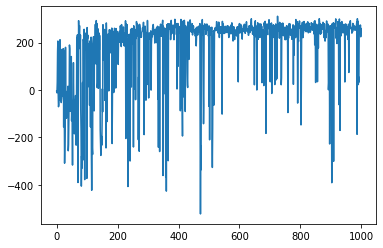

In [ ]:
figure_file_rew = 'lunar-lander-rewards-ddpg-next1000.jpg'
plt.plot(score_history)
plt.savefig(figure_file_rew)

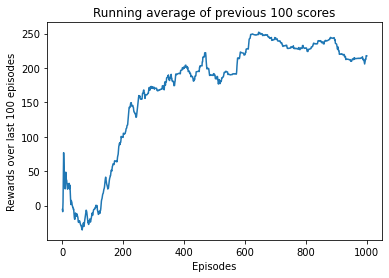

In [ ]:
filename = 'lunar-lander-ddpg-100avg-next1000.png'

x = [i+1 for i in range(num_episodes)]
plot_learning_curve(x,score_history,filename)